In [122]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
import logging
from src.utils.custom_formatter import setup_custom_logger
logger = setup_custom_logger(__name__, level=logging.DEBUG)

- Load dataset to have actual returns and market returns

In [3]:
from src import Analyzer
from src.utils.params import ReturnParams
from src import RiskTests

import numpy as np
import pandas as pd

return_params = ReturnParams(
    horizons={h for h in range(1,120+1)},  
    start_date=None,
#    end_date="2020-02-03",
    cumulative=False,
    append_start=False
)

an_wealth = Analyzer(compare_tickers=["VOO"], return_params=return_params, stocks_only=False, weights_application="wealth", dl_kwargs={"weights_method":"dollar"})
an_number = Analyzer(compare_tickers=["VT"], return_params=return_params, stocks_only=False, weights_application="number", dl_kwargs={"weights_method":"dollar"})

rt_number = RiskTests(an_number)
rt_wealth = RiskTests(an_wealth)

2025-05-30 11:02:58,575 - src.analyzer - INFO - ------------------------------ Analysis Started ------------------------------ (analyzer.py:80)
2025-05-30 11:03:04,617 - src.analyzer - INFO - ------------------------------ Analysis Started ------------------------------ (analyzer.py:80)


In [60]:
df_ret_number = an_number.build_returns()[0]
df_ret_number = df_ret_number.apply(np.exp)
df_ret_wealth = an_wealth.build_returns()[0]
df_ret_wealth = df_ret_wealth.apply(np.exp)


In [47]:
import numpy as np
from scipy import stats

def mean_diff_ci(a, b):

    # Sample statistics
    mean_diff = np.mean(a) - np.mean(b)
    n1, n2 = len(a), len(b)
    var1, var2 = np.var(a, ddof=1), np.var(b, ddof=1)  # sample variances

    # Standard error of the difference
    se_diff = np.sqrt(var1/n1 + var2/n2)

    # Degrees of freedom (Welch-Satterthwaite equation)
    df = (var1/n1 + var2/n2)**2 / ((var1**2)/(n1**2 * (n1-1)) + (var2**2)/(n2**2 * (n2-1)))

    # t-critical value for 95% CI
    alpha = 0.05
    t_crit = stats.t.ppf(1 - alpha/2, df)

    # Confidence interval
    ci_lower = mean_diff - t_crit * se_diff
    ci_upper = mean_diff + t_crit * se_diff

    return mean_diff, ci_lower, ci_upper 
    print(f"Mean difference: {mean_diff:.4f}")
    print(f"95% CI: ({ci_lower:.4f}, {ci_upper:.4f})")

In [32]:
rt_number.factors

,xmkt,smb,hml,rmw,cma,rf,umd,rh_portfolio,mkt,xr
2018-06-04,0.004355,0.0015,-0.0046,0.0106,-0.0030,0.00006,0.0017,0.007126,0.004415,0.007066
2018-06-05,0.001326,0.0079,-0.0043,0.0023,0.0011,0.00006,0.0029,0.009895,0.001386,0.009835
2018-06-06,0.007928,-0.0028,0.0019,-0.0002,0.0015,0.00006,-0.0001,0.001532,0.007988,0.001472
2018-06-07,-0.000531,-0.0024,0.0091,0.0017,0.0059,0.00006,-0.0091,-0.002143,-0.000471,-0.002203
2018-06-08,0.003080,0.0005,-0.0041,0.0027,-0.0019,0.00006,-0.0013,-0.005169,0.003140,-0.005229
...,...,...,...,...,...,...,...,...,...,...
2020-08-07,0.000521,0.0152,0.0234,0.0049,0.0017,0.00000,-0.0201,-0.014506,0.000521,-0.014506
2020-08-10,0.003188,0.0127,0.0166,0.0086,0.0124,0.00000,-0.0282,-0.000801,0.003188,-0.000801
2020-08-11,-0.008075,0.0018,0.0157,0.0089,0.0007,0.00000,-0.0221,-0.019462,-0.008075,-0.019462
2020-08-12,0.013700,-0.0081,-0.0130,0.0095,-0.0014,0.00000,0.0187,0.042312,0.013700,0.042312


## Welfare Loss

In [53]:
from src.utils.metrics import find_gamma_certainty_equivalent_cutoff
import pandas as pd


days = [1, 5, 30, 60]

df_gamma = pd.DataFrame()

df = pd.DataFrame()

for d in days:

    #mkt = f"VOO_{d}_return"
    #r = f"rh_portfolio_{d}_return"
    mkt = f"xmkt"
    r = f"xr"



    df_number = rt_number.resample_factors(f"{d}D") + 1
    df_wealth = rt_wealth.resample_factors(f"{d}D") + 1
    parametric = False



    # keep the scalar returned by the CE condition
    gamma_hat_number = find_gamma_certainty_equivalent_cutoff(df_number[r],
                                                df_number[mkt],
                                                parametric=parametric)

    gamma_hat_wealth = find_gamma_certainty_equivalent_cutoff(df_wealth[r],
                                                df_wealth[mkt],
                                                parametric=parametric)
    

    df.loc[f"{d} Days", "Fedyk - World ETF"] = gamma_hat_wealth
    df.loc[f"{d} Days", "Number - World ETF"] = gamma_hat_number


df.round(3)


,Fedyk - World ETF,Number - World ETF
1 Days,4.221,4.147
5 Days,3.658,3.387
30 Days,3.762,2.262
60 Days,4.099,2.057


In [175]:
def direct_ce(returns, gamma):
    if not np.isclose(gamma, 1):

        returns_modified = returns**(1-gamma)
        returns_modified_bar = np.mean(returns_modified)

        ce = returns_modified_bar**(1/(1-gamma))

    else:
        returns_modified = np.log(returns) 
        returns_modified_bar = np.mean(returns_modified)
        ce = returns_modified_bar + 1

    return ce 

- Utility 

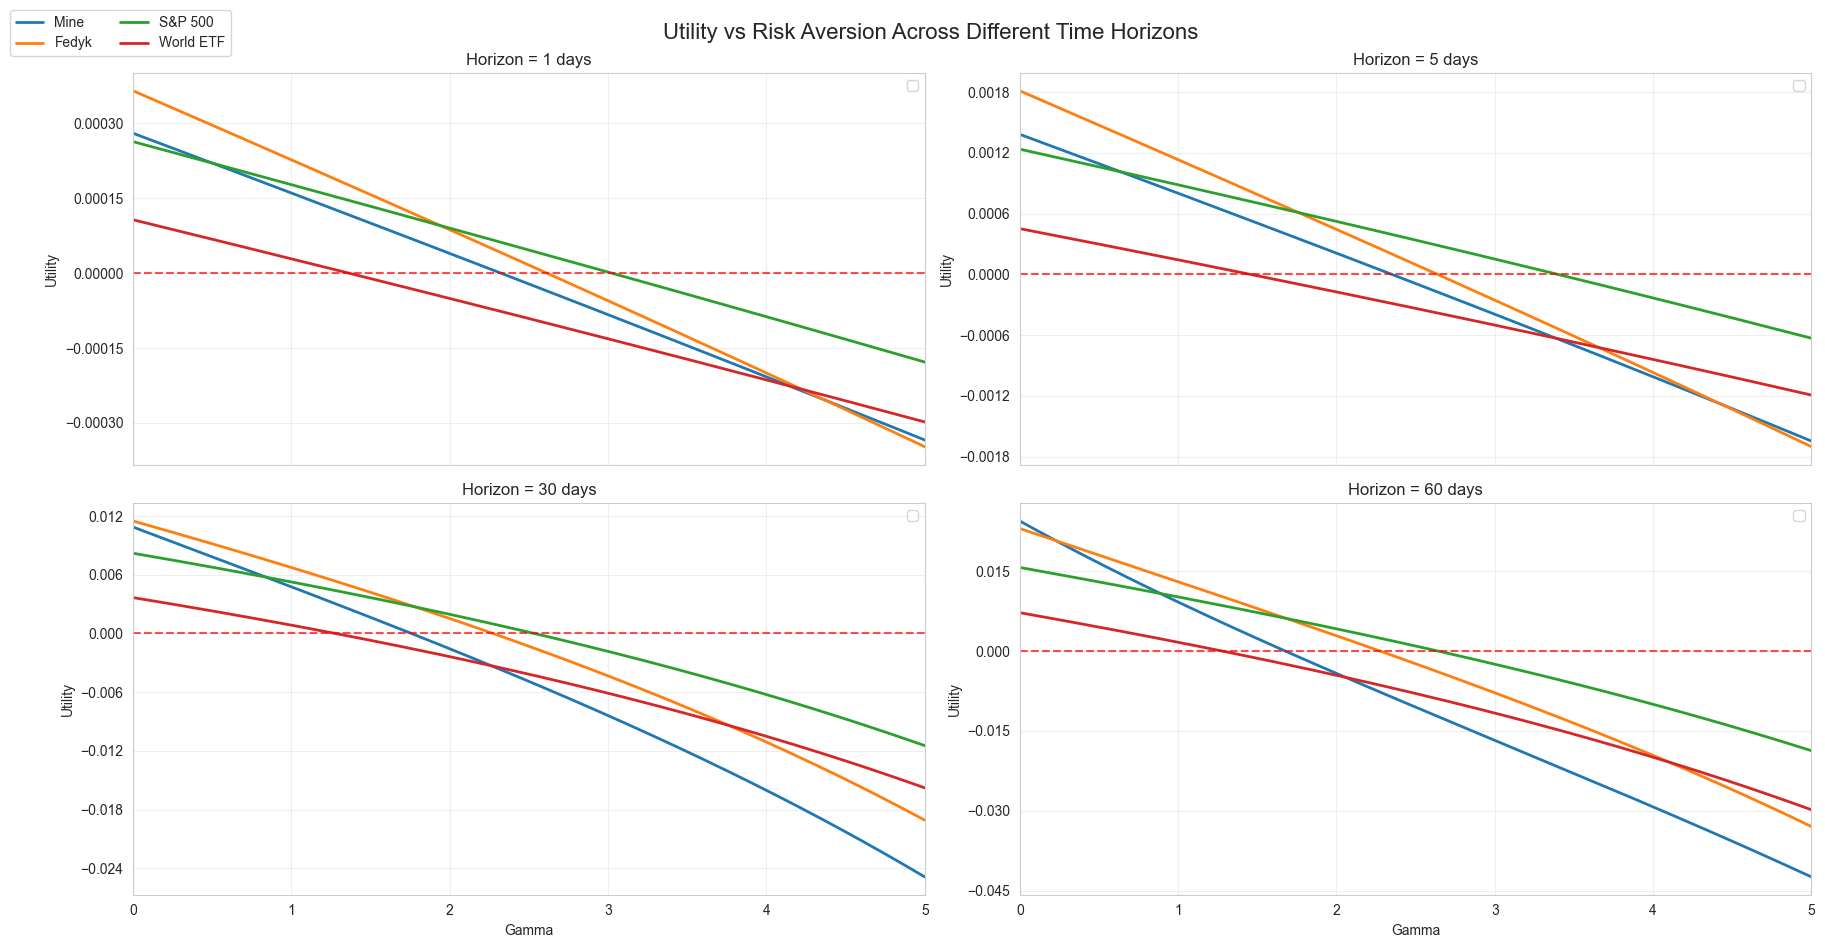

In [85]:
from src.utils.metrics import crra_certainty_equivalent_utility, compute_crra_utility, crra_ce_returns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

sns.set_style("whitegrid")

# Different d values for each subplot
d_values = [1, 5, 30, 60]

lo = 0
hi = 5
gap = 5
gammas = np.linspace(lo, hi, 1001)

# Create 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=True)
fig.suptitle('Utility vs Risk Aversion Across Different Time Horizons', fontsize=16, y=0.98)

# Flatten axes for easier iteration
axes_flat = axes.flatten()
lines, labels = [], []

for idx, d in enumerate(d_values):
    ax = axes_flat[idx]
    
    # Define market and portfolio variables for current d
    mkt = f"xmkt"
    r = f"xr"
    
    # Resample data for current d
    df_num = rt_number.resample_factors(f"{d}D") + 1
    df_wealth = rt_wealth.resample_factors(f"{d}D") + 1
    
    # Calculate welfare measures
    ce_num = [compute_crra_utility(df_num[r], g) for g in gammas]
    ce_wealth = [compute_crra_utility(df_wealth[r], g) for g in gammas]
    ce_voo = [compute_crra_utility(df_wealth[mkt], g) for g in gammas]
    ce_vt = [compute_crra_utility(df_num[mkt], g) for g in gammas]
    
    # Plot on current subplot
    line1 = ax.plot(gammas, ce_num, color='C0', linewidth=2, label='_nolegend_')
    line2 = ax.plot(gammas, ce_wealth, color='C1', linewidth=2, label='_nolegend_')
    line3 = ax.plot(gammas, ce_voo, color='C2', linewidth=2, label='_nolegend_')
    line4 = ax.plot(gammas, ce_vt, color='C3', linewidth=2, label='_nolegend_')
    ax.axhline(0, color='red', linestyle='--', alpha=0.7)
    
    if idx == 0:
        lines.append(line1[0])
        lines.append(line2[0])
        lines.append(line3[0])
        lines.append(line4[0])
        labels.append('Mine')
        labels.append('Fedyk')
        labels.append('S&P 500')
        labels.append('World ETF')

    if ax.get_legend() is not None:
        ax.get_legend().remove()

    # Customize subplot
    ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=7))
    ax.set_xlabel('Gamma' if (idx >= 2) else None)
    ax.set_xlim((lo, hi))
    ax.set_ylabel('Utility')
    ax.set_title(f'Horizon = {d} days')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)


# Adjust layout to prevent overlap
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.05, 1),
           ncol=(len(labels)//4+1), frameon=True, fontsize='medium')

plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.subplots_adjust(top=0.93)  # Make room for suptitle
plt.show()

- Portfolios - Rf

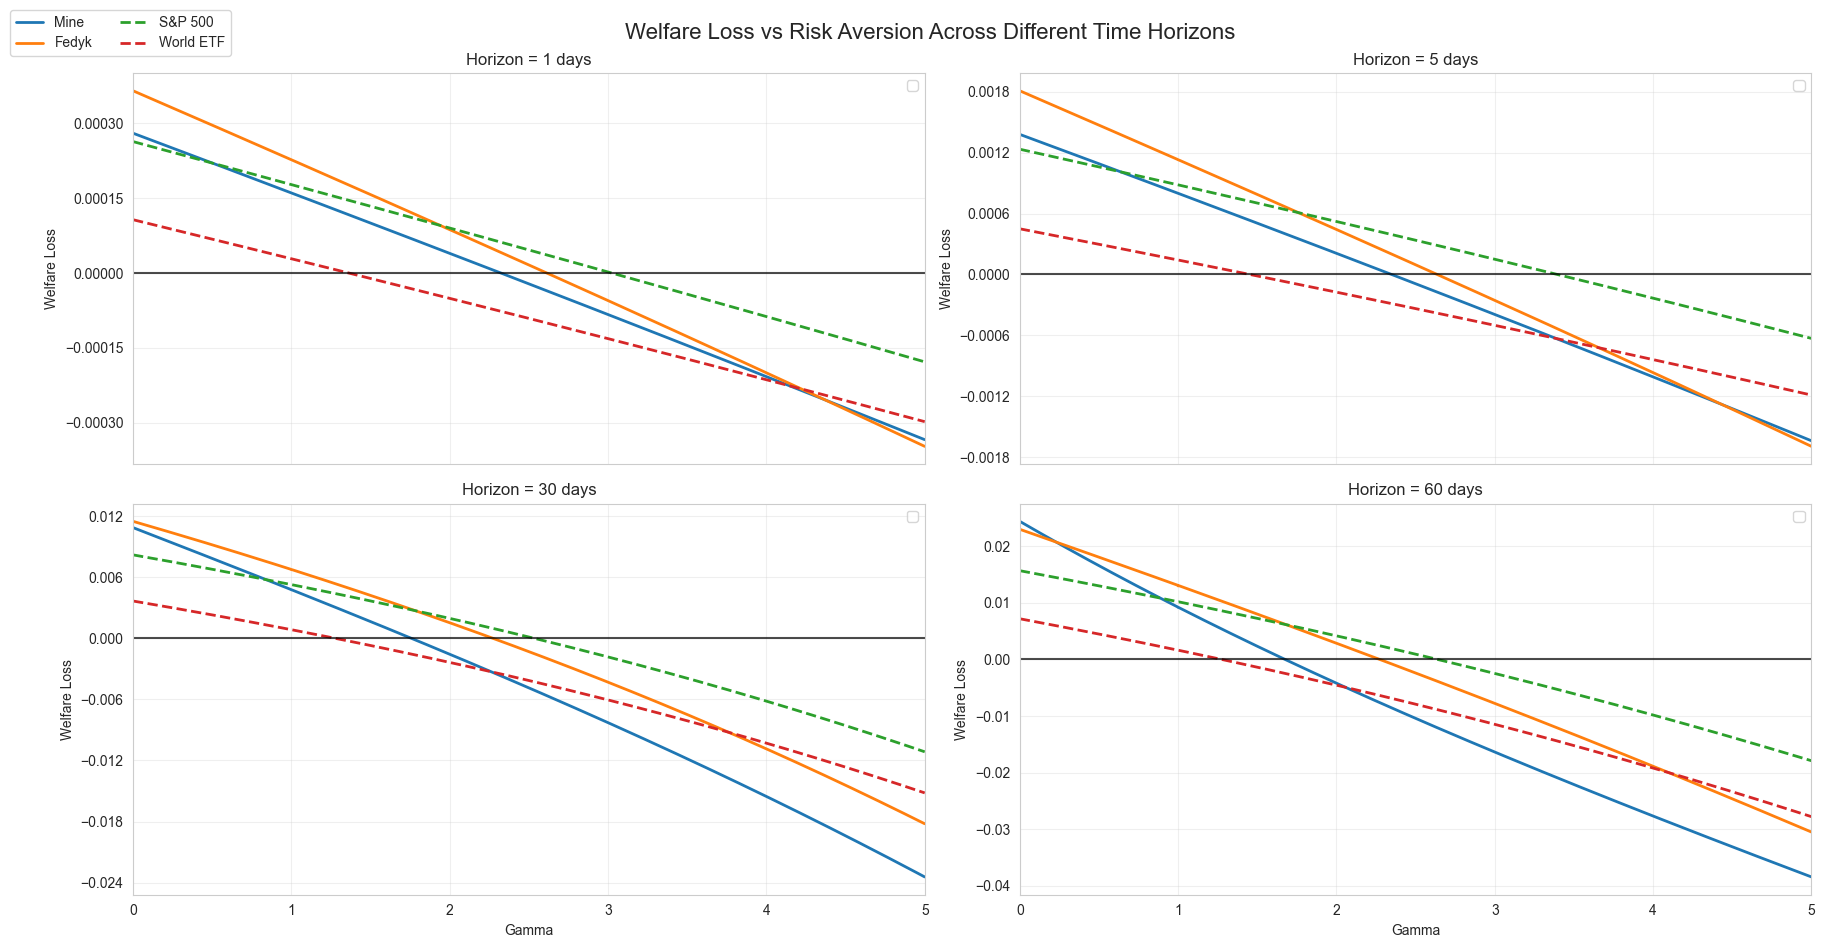

In [89]:
from src.utils.metrics import crra_certainty_equivalent_utility, compute_crra_utility, crra_ce_returns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

sns.set_style("whitegrid")

# Different d values for each subplot
d_values = [1, 5, 30, 60]

lo = 0
hi = 5
gap = 5
gammas = np.linspace(lo, hi, 1001)

# Create 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=True)
fig.suptitle('Welfare Loss vs Risk Aversion Across Different Time Horizons', fontsize=16, y=0.98)

# Flatten axes for easier iteration
axes_flat = axes.flatten()
lines, labels = [], []

for idx, d in enumerate(d_values):
    ax = axes_flat[idx]
    
    # Define market and portfolio variables for current d
    mkt = f"xmkt"
    r = f"xr"
    
    # Resample data for current d
    df_num = rt_number.resample_factors(f"{d}D") + 1
    df_wealth = rt_wealth.resample_factors(f"{d}D") + 1
    
    # Calculate welfare measures
    ce_num = [crra_ce_returns(df_num[r], g)-1 for g in gammas]
    ce_wealth = [crra_ce_returns(df_wealth[r], g)-1 for g in gammas]
    ce_voo = [crra_ce_returns(df_wealth[mkt], g)-1 for g in gammas]
    ce_vt = [crra_ce_returns(df_num[mkt], g)-1 for g in gammas]
    
    # Plot on current subplot
    line1 = ax.plot(gammas, ce_num, color='C0', linewidth=2, label='_nolegend_')
    line2 = ax.plot(gammas, ce_wealth, color='C1', linewidth=2, label='_nolegend_')
    line3 = ax.plot(gammas, ce_voo, color='C2', linestyle="--", linewidth=2, label='_nolegend_')
    line4 = ax.plot(gammas, ce_vt, color='C3', linestyle="--", linewidth=2, label='_nolegend_')
    ax.axhline(0, color='black', linestyle='-', alpha=0.7)
    
    if idx == 0:
        lines.append(line1[0])
        lines.append(line2[0])
        lines.append(line3[0])
        lines.append(line4[0])
        labels.append('Mine')
        labels.append('Fedyk')
        labels.append('S&P 500')
        labels.append('World ETF')

    if ax.get_legend() is not None:
        ax.get_legend().remove()

    # Customize subplot
    ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=7))
    ax.set_xlabel('Gamma' if (idx >= 2) else None)
    ax.set_xlim((lo, hi))
    ax.set_ylabel('Welfare Loss')
    ax.set_title(f'Horizon = {d} days')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)


# Adjust layout to prevent overlap
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.05, 1),
           ncol=(len(labels)//4+1), frameon=True, fontsize='medium')

plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.subplots_adjust(top=0.93)  # Make room for suptitle
plt.show()

**Test**
- Plotting $\alpha$ and $\gamma$, what if they didn't invest everything in the risky asset?

100%|██████████| 100/100 [00:02<00:00, 44.97it/s]


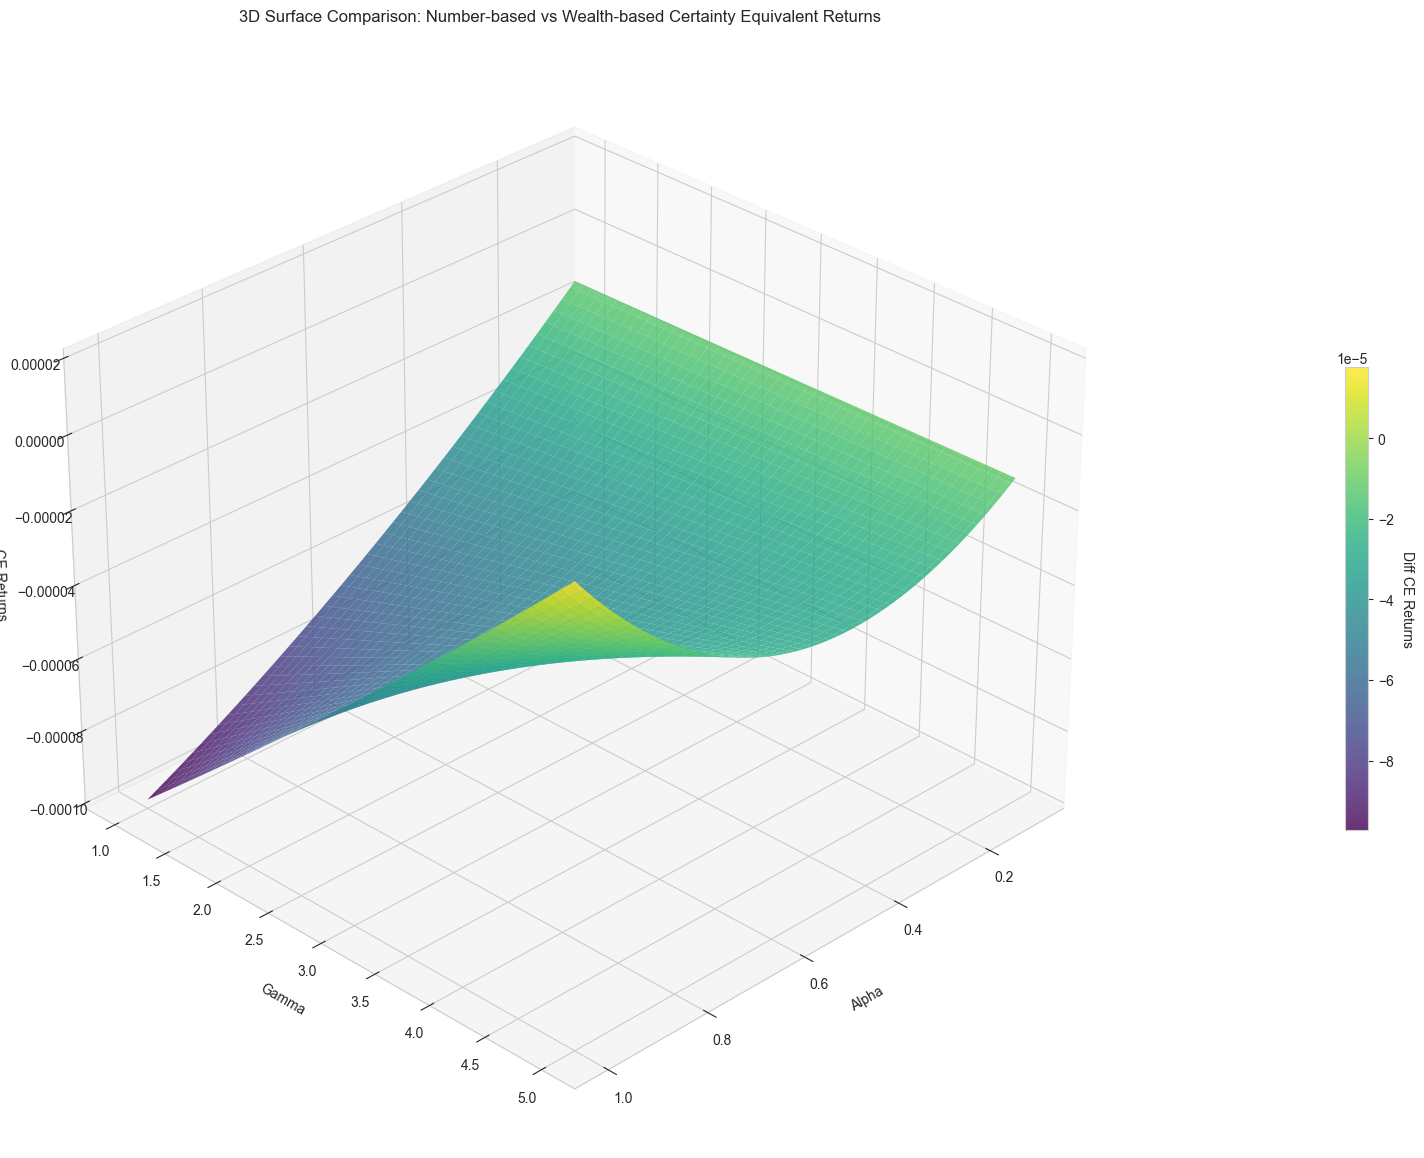

Original alphas range: 0.100 to 1.000
Reversed alphas: first=1.000, last=0.100
Alphas shape: (100,)
Gammas shape: (100,)
DataFrame shape: (100, 100)
A_mesh shape: (100, 100)
G_mesh shape: (100, 100)
Z shape: (100, 100)
Data range: -0.0005 to 0.0002


In [83]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# Your data generation code for both datasets
alphas = np.linspace(0.1, 1, 100)
gammas = np.linspace(1, 5, 100)

# Create DataFrames for both number and wealth
df_surf_num = pd.DataFrame(index=alphas, columns=gammas)
df_surf_wealth = pd.DataFrame(index=alphas, columns=gammas)

for a in tqdm(alphas):
    # Number-based calculation
    df_num = rt_number.factors*a + 1
    ce_num = [crra_ce_returns(df_num["xr"], g)-1 for g in gammas]
    df_surf_num.loc[a, :] = ce_num
    
    # Wealth-based calculation
    df_wealth = rt_wealth.factors*a + 1
    ce_wealth = [crra_ce_returns(df_wealth["xr"], g)-1 for g in gammas]
    df_surf_wealth.loc[a, :] = ce_wealth

# CORRECTED 3D PLOTTING CODE:

# 1) Reverse alphas to display in increasing order and reorder DataFrame
alphas_reversed = alphas[::-1]  # Reverse the array
df_surf_num_reversed = df_surf_num.loc[alphas_reversed]
df_surf_wealth_reversed = df_surf_wealth.loc[alphas_reversed]

# 2) Create meshgrid from the reversed alpha and gamma values
A_mesh, G_mesh = np.meshgrid(alphas_reversed, gammas)

# 3) Get Z values - transpose the reversed DataFrame values
Z1 = df_surf_num_reversed.values.T
Z2 = df_surf_wealth_reversed.values.T
Z_diff = Z1-Z2

# 3) Create 3D plot
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# 4) Plot the surface with correct orientation
#surf1 = ax.plot_surface(
#    A_mesh, G_mesh, Z1,
#    cmap='flare',
#    alpha=0.8,
#    edgecolor='none',
#    linewidth=0,
#    antialiased=True
#)
#surf2 = ax.plot_surface(
#    A_mesh, G_mesh, Z2,
#    cmap='viridis',
#    alpha=0.8,
#    edgecolor='none',
#    linewidth=0,
#    antialiased=True
#)
diff = ax.plot_surface(
    A_mesh, G_mesh, Z_diff,
    cmap='viridis',
    alpha=0.8,
    edgecolor='none',
    linewidth=0,
    antialiased=True
)

# 6) Add colorbars for both surfaces
#cbar1 = fig.colorbar(surf1, ax=ax, shrink=0.4, aspect=20, pad=0.1)
#cbar1.set_label('Number-based CE Returns', rotation=270, labelpad=15)
#
#cbar2 = fig.colorbar(surf2, ax=ax, shrink=0.4, aspect=20, pad=0.15)
#cbar2.set_label('Wealth-based CE Returns', rotation=270, labelpad=15)

cbar3 = fig.colorbar(diff, ax=ax, shrink=0.4, aspect=20, pad=0.15)
cbar3.set_label('Diff CE Returns', rotation=270, labelpad=15)

# 7) Set labels and title
ax.set_xlabel('Alpha', labelpad=10)
ax.set_ylabel('Gamma', labelpad=10)
ax.set_zlabel('CE Returns', labelpad=10)
ax.set_title('3D Surface Comparison: Number-based vs Wealth-based Certainty Equivalent Returns', pad=20)

# 8) Adjust viewing angle for better visualization
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()

# Optional: Print some diagnostics to verify the data structure
print(f"Original alphas range: {alphas.min():.3f} to {alphas.max():.3f}")
print(f"Reversed alphas: first={alphas_reversed[0]:.3f}, last={alphas_reversed[-1]:.3f}")
print(f"Alphas shape: {alphas_reversed.shape}")
print(f"Gammas shape: {gammas.shape}")
print(f"DataFrame shape: {df_surf_num_reversed.shape}")
print(f"A_mesh shape: {A_mesh.shape}")
print(f"G_mesh shape: {G_mesh.shape}")
print(f"Z shape: {Z1.shape}")
print(f"Data range: {Z1.min():.4f} to {Z1.max():.4f}")

- RH - Market

### Heatmaps

In [ ]:
import pandas as pd
from tqdm import tqdm


lo = 2
hi = 5
gap = 5
gammas = np.linspace(lo, hi, 100)

df_plot_number = pd.DataFrame(columns=gammas)

for d in tqdm(range(1,60+1)):
    #print(d)

    df = df_ret_number[[f"rh_portfolio_{d}_return", f"VOO_{d}_return"]].dropna().copy().apply(lambda x: x**(1/d))
    #df = rt.resample_factors(f"{d}D")+1
    #df = df[["xr", "xmkt"]]
    #df = df.dropna().copy().apply(lambda x: x**(1/d))


    utilities_xr  = []
    utilities_xmkt = []     
    utilities_voo = []
    ut_diff = []

    for g in gammas:
        #utilities_xr.append(compute_crra_utility(df["xr"], g, mean=True, confint=False))
        #utilities_xmkt.append(compute_crra_utility(df["xmkt"], g, mean=True, confint=False))
        ut_xr = compute_crra_utility(df[f"rh_portfolio_{d}_return"], g, mean=False)
        ut_xmkt = compute_crra_utility(df[f"VOO_{d}_return"], g, mean=False)

        ut_diff.append(mean_diff_ci(ut_xr, ut_xmkt))

        utilities_xr.append(np.mean(ut_xr))
        utilities_voo.append(np.mean(ut_xmkt))


    welfare_xr = [crra_certainty_equivalent_utility(utilities_xr[g], gammas[g]) for g in range(len(gammas))]
    welfare_vt = [crra_certainty_equivalent_utility(utilities_voo[g], gammas[g]) for g in range(len(gammas))]

    welfare_loss = [x-m for x,m in zip(welfare_xr, welfare_vt)]
    #welfare_loss = [x-1 for x in welfare_xr]

    df_plot_number.loc[d,:] = welfare_loss


  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:03<00:00, 18.34it/s]


In [ ]:
import pandas as pd
from tqdm import tqdm


lo = 2
hi = 5
gap = 5
gammas = np.linspace(lo, hi, 500)

df_plot_wealth = pd.DataFrame(columns=gammas)

for d in tqdm(range(1,60+1)):
    #print(d)

    df = df_ret_wealth[[f"rh_portfolio_{d}_return", f"VOO_{d}_return"]].dropna().copy().apply(lambda x: x**(1/d))
    #df = rt.resample_factors(f"{d}D")+1
    #df = df[["xr", "xmkt"]]
    #df = df.dropna().copy().apply(lambda x: x**(1/d))


    utilities_xr  = []
    utilities_xmkt = []     
    utilities_voo = []
    ut_diff = []

    for g in gammas:
        #utilities_xr.append(compute_crra_utility(df["xr"], g, mean=True, confint=False))
        #utilities_xmkt.append(compute_crra_utility(df["xmkt"], g, mean=True, confint=False))
        ut_xr = compute_crra_utility(df[f"rh_portfolio_{d}_return"], g, mean=False)
        ut_xmkt = compute_crra_utility(df[f"VOO_{d}_return"], g, mean=False)

        ut_diff.append(mean_diff_ci(ut_xr, ut_xmkt))

        utilities_xr.append(np.mean(ut_xr))
        utilities_voo.append(np.mean(ut_xmkt))


    welfare_xr = [crra_certainty_equivalent_utility(utilities_xr[g], gammas[g]) for g in range(len(gammas))]
    welfare_vt = [crra_certainty_equivalent_utility(utilities_voo[g], gammas[g]) for g in range(len(gammas))]

    welfare_loss = [x-m for x,m in zip(welfare_xr, welfare_vt)]
    #welfare_loss = [x-1 for x in welfare_xr]

    df_plot_wealth.loc[d,:] = welfare_loss


100%|██████████| 60/60 [00:16<00:00,  3.60it/s]


In [ ]:
df_plot_number = df_plot_number.apply(pd.to_numeric, errors='coerce')
df_plot_number.columns = [format(c, ".2f") for c in df_plot_number.columns]
df_numeric_number = df_plot_number
#df_numeric = df_numeric.replace(0, 0.000001)
df_numeric_number


,2.000,2.030,2.061,2.091,2.121,2.152,2.182,2.212,2.242,2.273,...,4.727,4.758,4.788,4.818,4.848,4.879,4.909,4.939,4.970,5.000
1,-0.000043,-0.000045,-0.000046,-0.000048,-0.000049,-0.000051,-0.000052,-0.000054,-0.000055,-0.000057,...,-0.000184,-0.000185,-0.000187,-0.000189,-0.000190,-0.000192,-0.000193,-0.000195,-0.000197,-0.000198
2,-0.000042,-0.000043,-0.000044,-0.000044,-0.000045,-0.000046,-0.000047,-0.000048,-0.000049,-0.000050,...,-0.000125,-0.000125,-0.000126,-0.000127,-0.000128,-0.000129,-0.000130,-0.000131,-0.000132,-0.000133
3,-0.000057,-0.000057,-0.000058,-0.000059,-0.000059,-0.000060,-0.000061,-0.000061,-0.000062,-0.000062,...,-0.000114,-0.000115,-0.000115,-0.000116,-0.000117,-0.000117,-0.000118,-0.000119,-0.000119,-0.000120
4,-0.000062,-0.000062,-0.000063,-0.000063,-0.000064,-0.000064,-0.000065,-0.000065,-0.000066,-0.000066,...,-0.000108,-0.000109,-0.000109,-0.000110,-0.000110,-0.000111,-0.000111,-0.000112,-0.000112,-0.000113
5,-0.000059,-0.000060,-0.000060,-0.000061,-0.000061,-0.000062,-0.000062,-0.000063,-0.000063,-0.000064,...,-0.000102,-0.000102,-0.000103,-0.000103,-0.000104,-0.000104,-0.000105,-0.000105,-0.000106,-0.000106
6,-0.000053,-0.000054,-0.000054,-0.000055,-0.000055,-0.000056,-0.000056,-0.000056,-0.000057,-0.000057,...,-0.000092,-0.000092,-0.000092,-0.000093,-0.000093,-0.000094,-0.000094,-0.000095,-0.000095,-0.000095
7,-0.000048,-0.000049,-0.000049,-0.000050,-0.000050,-0.000050,-0.000051,-0.000051,-0.000052,-0.000052,...,-0.000084,-0.000084,-0.000085,-0.000085,-0.000086,-0.000086,-0.000086,-0.000087,-0.000087,-0.000088
8,-0.000046,-0.000046,-0.000047,-0.000047,-0.000047,-0.000048,-0.000048,-0.000048,-0.000049,-0.000049,...,-0.000078,-0.000079,-0.000079,-0.000079,-0.000080,-0.000080,-0.000080,-0.000081,-0.000081,-0.000082
9,-0.000046,-0.000046,-0.000047,-0.000047,-0.000047,-0.000048,-0.000048,-0.000048,-0.000049,-0.000049,...,-0.000076,-0.000076,-0.000077,-0.000077,-0.000077,-0.000078,-0.000078,-0.000078,-0.000079,-0.000079
10,-0.000048,-0.000048,-0.000048,-0.000049,-0.000049,-0.000049,-0.000049,-0.000050,-0.000050,-0.000050,...,-0.000075,-0.000076,-0.000076,-0.000076,-0.000076,-0.000077,-0.000077,-0.000077,-0.000078,-0.000078


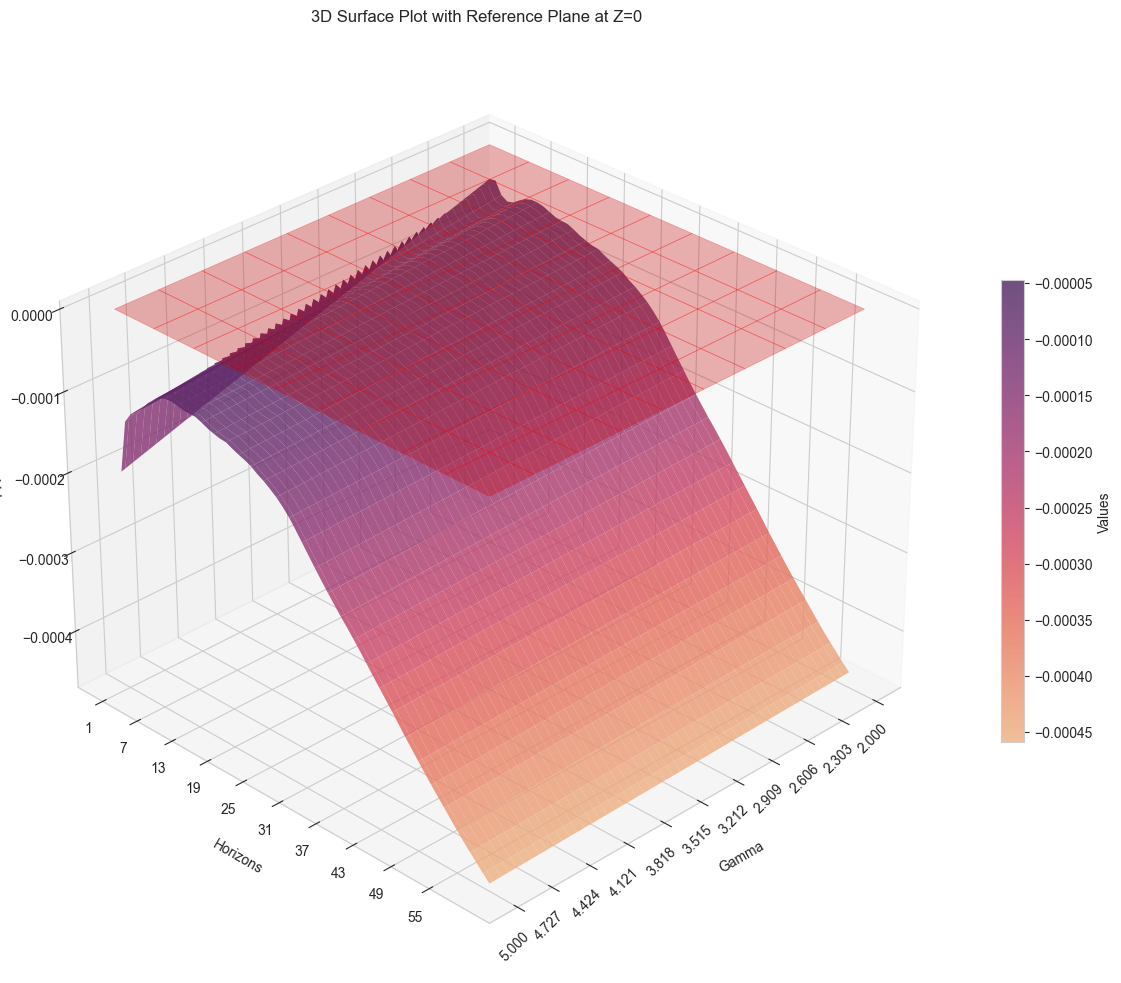

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# 1) Prepare the X/Y grid for 3D plotting:
X = np.arange(df_numeric_number.shape[1])
Y = np.arange(df_numeric_number.shape[0])
Xg, Yg = np.meshgrid(X, Y)

# 2) Get Z values (your data):
Z1 = df_numeric_number.values

# 3) Create 3D plot:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# 4) Plot the surface:
surf = ax.plot_surface(
    Xg, Yg, Z1,
    cmap='flare',
    alpha=0.8,
    edgecolor='none',
    linewidth=0,
    antialiased=True
)

# 5) Add reference plane at z=0 (optional):
# Create a mesh for the reference plane
X_plane, Y_plane = np.meshgrid(
    np.linspace(0, df_numeric_number.shape[1]-1, 10),
    np.linspace(0, df_numeric_number.shape[0]-1, 10)
)
Z_plane = np.zeros_like(X_plane)

ax.plot_surface(
    X_plane, Y_plane, Z_plane,
    alpha=0.3,
    color='red',
    edgecolor='red',
    linewidth=0.5
)

# 6) Add colorbar:
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=20, label='Values')

# 7) Set up ticks and labels:
# X-axis (Gamma) ticks
positions_x = np.arange(len(df_plot_number.columns))[::10]
positions_x = np.append(positions_x, len(df_plot_number.columns)-1)
labels_x = df_plot_number.columns[::10]
labels_x = list(labels_x)
labels_x.append(df_plot_number.columns[-1])

ax.set_xticks(positions_x)
ax.set_xticklabels(labels_x, rotation=45, ha='right')

# Y-axis (Horizons) - show every few ticks to avoid crowding
positions_y = np.arange(len(df_plot_number.index))[::max(1, len(df_plot_number.index)//10)]
ax.set_yticks(positions_y)
ax.set_yticklabels(df_plot_number.index[positions_y])

# 8) Labels and title:
ax.set_xlabel('Gamma', labelpad=10)
ax.set_ylabel('Horizons', labelpad=10)
ax.set_zlabel('Values', labelpad=10)
ax.set_title('3D Surface Plot with Reference Plane at Z=0', pad=20)

# 9) Adjust viewing angle for better visualization:
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()

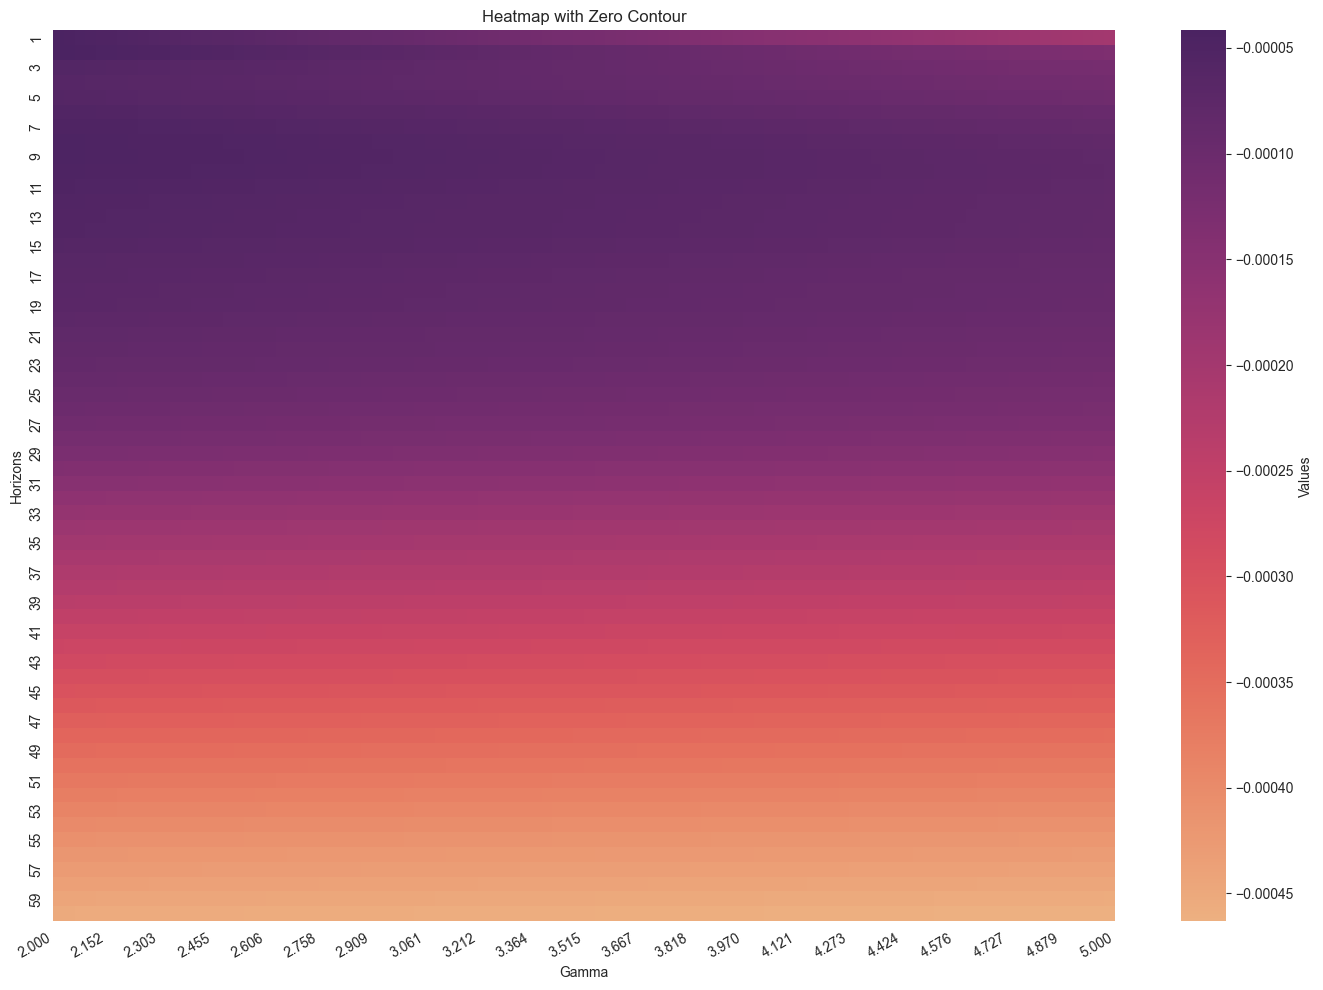

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.ticker as mticker

# — assume df_numeric is your fully numeric DataFrame —

# 1) Prepare the X/Y grid for contouring:
X = np.arange(df_numeric_number.shape[1])
Y = np.arange(df_numeric_number.shape[0])
Xg, Yg = np.meshgrid(X, Y)

# 2) Plot heatmap:
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(df_numeric_number, ax=ax, cmap='flare', cbar_kws={'label':'Values'})

# 3) Overlay zero‐contour:
#    levels=[0] draws only the line where value == 0
cs = ax.contour(
    Xg + 0.5,         # shift so contours align with cell centers
    Yg + 0.5,
    df_numeric_number.values,
    levels=[0],
    colors='red',   # pick a contrasting color
    linewidths=2
)

# 4) (Optional) Label the contour:
ax.clabel(cs, colors='red', fontsize=12)

# 5) Tidy up ticks and labels:
#    Show every 5th column tick as before
import numpy as np

positions = np.arange(len(df_plot_number.columns))[::5]
positions = np.append(positions, len(df_plot_number.columns))
labels = df_plot_number.columns[::5]
labels = list(labels)
labels.append(df_plot_number.columns[-1])

ax.set_xticks(positions) 
ax.set_xticklabels(labels, rotation=30, ha='right')
ax.set_xlabel('Gamma')
ax.set_ylabel('Horizons')
ax.set_title('Heatmap with Zero Contour')

plt.tight_layout()
plt.show()


In [ ]:
df_plot_wealth = df_plot_wealth.apply(pd.to_numeric, errors='coerce')
#df_plot_wealth.columns = [format(c, ".2f") for c in df_plot_wealth.columns]
df_numeric_wealth = df_plot_wealth
#df_numeric = df_numeric.replace(0, 0.000001)
df_numeric_wealth


ValueError: Unknown format code 'f' for object of type 'str'

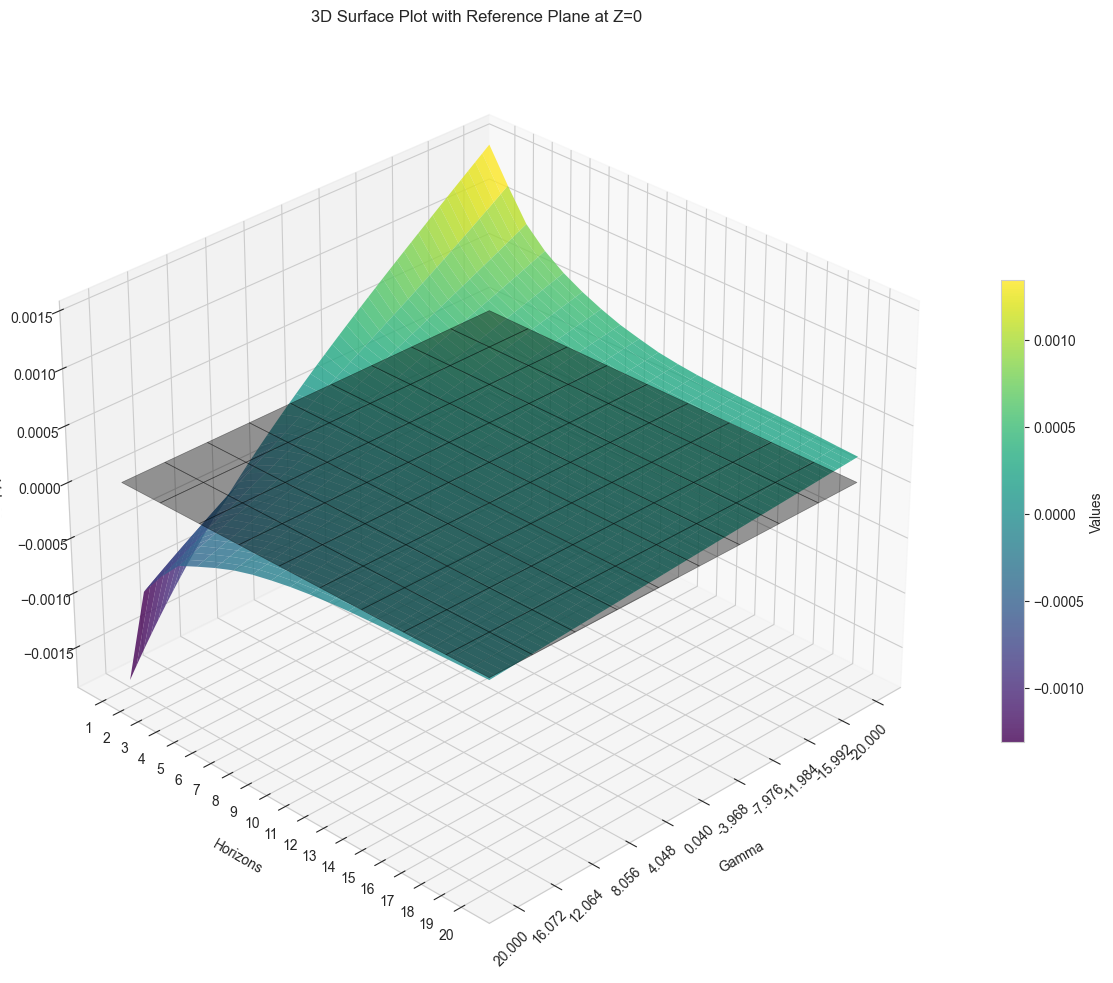

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# 1) Prepare the X/Y grid for 3D plotting:
X = np.arange(df_numeric_wealth.shape[1])
Y = np.arange(df_numeric_wealth.shape[0])
Xg, Yg = np.meshgrid(X, Y)

# 2) Get Z values (your data):
Z1 = df_numeric_wealth.values

# 3) Create 3D plot:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# 4) Plot the surface:
surf = ax.plot_surface(
    Xg, Yg, Z1,
    cmap='viridis',
    alpha=0.8,
    edgecolor='none',
    linewidth=0,
    antialiased=True
)

# 5) Add reference plane at z=0 (optional):
# Create a mesh for the reference plane
X_plane, Y_plane = np.meshgrid(
    np.linspace(0, df_numeric_wealth.shape[1]-1, 10),
    np.linspace(0, df_numeric_wealth.shape[0]-1, 10)
)
Z_plane = np.zeros_like(X_plane)

ax.plot_surface(
    X_plane, Y_plane, Z_plane,
    alpha=0.4,
    color='black',
    edgecolor='black',
    linewidth=0.5
)

# 6) Add colorbar:
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=20, label='Values')

# 7) Set up ticks and labels:
# X-axis (Gamma) ticks
positions_x = np.arange(len(df_numeric_wealth.columns))[::50]
positions_x = np.append(positions_x, len(df_numeric_wealth.columns)-1)
labels_x = df_numeric_wealth.columns[::50]
labels_x = list(labels_x)
labels_x.append(df_numeric_wealth.columns[-1])

ax.set_xticks(positions_x)
ax.set_xticklabels(labels_x, rotation=45, ha='right')

# Y-axis (Horizons) - show every few ticks to avoid crowding
positions_y = np.arange(len(df_numeric_wealth.index))[::1]
ax.set_yticks(positions_y)
ax.set_yticklabels(df_numeric_wealth.index[positions_y])

# 8) Labels and title:
ax.set_xlabel('Gamma', labelpad=10)
ax.set_ylabel('Horizons', labelpad=10)
ax.set_zlabel('Values', labelpad=10)
ax.set_title('3D Surface Plot with Reference Plane at Z=0', pad=20)

# 9) Adjust viewing angle for better visualization:
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()

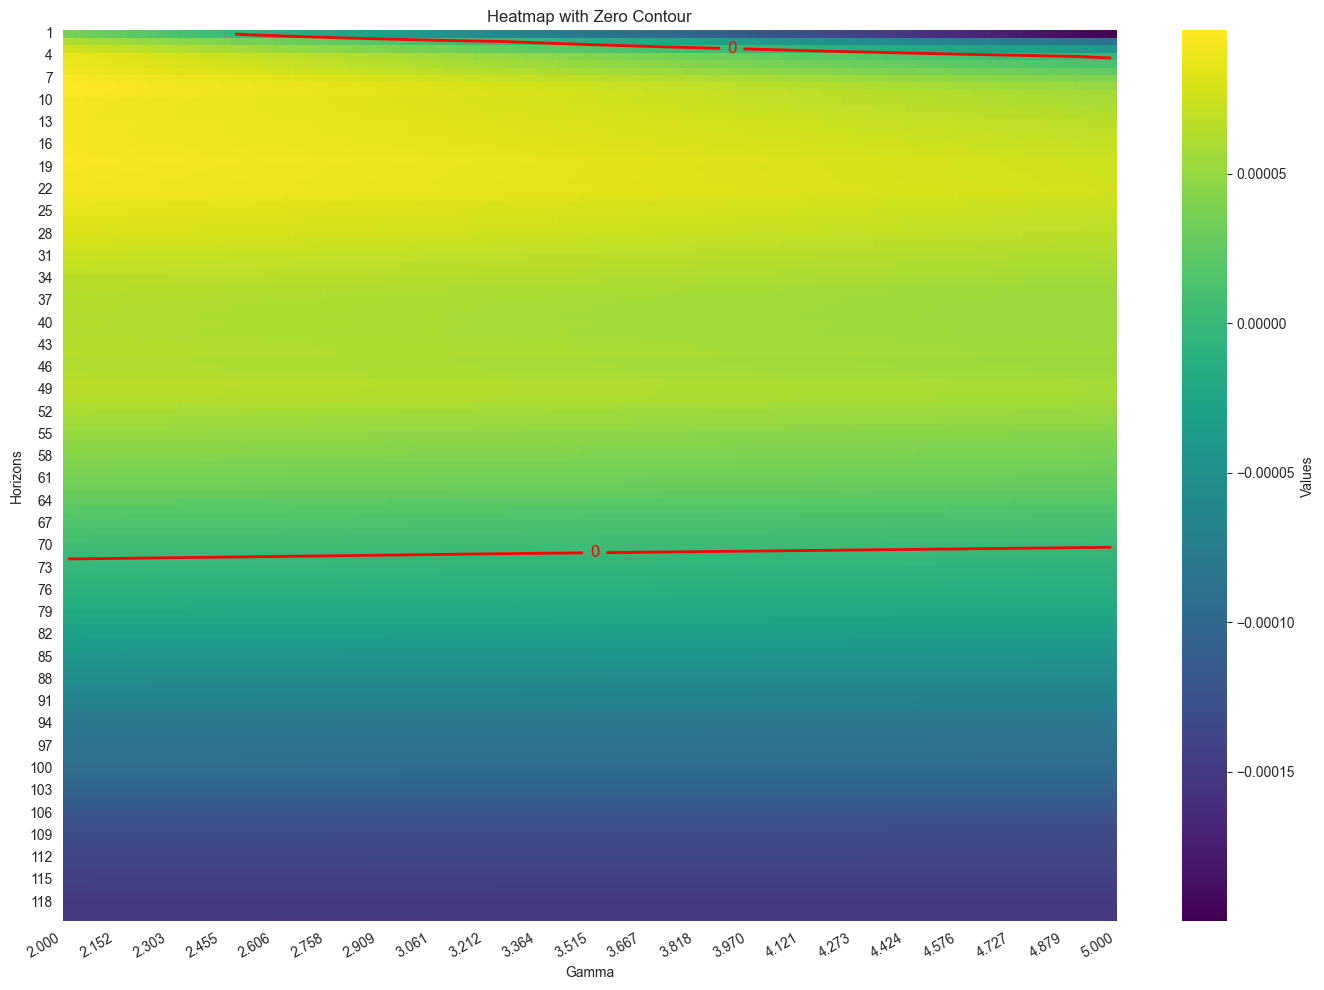

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.ticker as mticker

# — assume df_numeric is your fully numeric DataFrame —

# 1) Prepare the X/Y grid for contouring:
X = np.arange(df_numeric_wealth.shape[1])
Y = np.arange(df_numeric_wealth.shape[0])
Xg, Yg = np.meshgrid(X, Y)

# 2) Plot heatmap:
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(df_numeric_wealth, ax=ax, cmap='viridis', cbar_kws={'label':'Values'})

# 3) Overlay zero‐contour:
#    levels=[0] draws only the line where value == 0
cs = ax.contour(
    Xg + 0.5,         # shift so contours align with cell centers
    Yg + 0.5,
    df_numeric_wealth.values,
    levels=[0],
    colors='red',   # pick a contrasting color
    linewidths=2
)

# 4) (Optional) Label the contour:
ax.clabel(cs, colors='red', fontsize=12)

# 5) Tidy up ticks and labels:
#    Show every 5th column tick as before
import numpy as np

positions = np.arange(len(df_plot_wealth.columns))[::5]
positions = np.append(positions, len(df_plot_wealth.columns))
labels = df_plot_wealth.columns[::5]
labels = list(labels)
labels.append(df_plot_wealth.columns[-1])

ax.set_xticks(positions) 
ax.set_xticklabels(labels, rotation=30, ha='right')
ax.set_xlabel('Gamma')
ax.set_ylabel('Horizons')
ax.set_title('Heatmap with Zero Contour')

plt.tight_layout()
plt.show()


### All possible timeframes

In [3]:
%load_ext autoreload
%autoreload 2

In [ ]:
from src import Analyzer
from src import RiskTests
from src.utils.params import ReturnParams

return_params = ReturnParams(
    horizons={},  
    start_date=None,
#    end_date="2020-02-03",
    cumulative=False,
    append_start=False
)

an_wealth = Analyzer(compare_tickers=[], return_params=return_params, stocks_only=False, weights_application="number", dl_kwargs={"weights_method":"dollar"})


rt_wealth = RiskTests(an_wealth)



2025-05-02 12:41:07,298 - src.analyzer - INFO - ############################## Analysis Started ############################## (analyzer.py:80)
2025-05-02 12:41:13,687 - src.analyzer - WARNING - Empty dataframe produced for tickers: [] (analyzer.py:172)


In [ ]:
all_ret_df = rt_wealth.build_all_pairs_dataframe()


100%|██████████| 144991/144991 [00:19<00:00, 7497.32it/s] 


Gamma: -5.43728


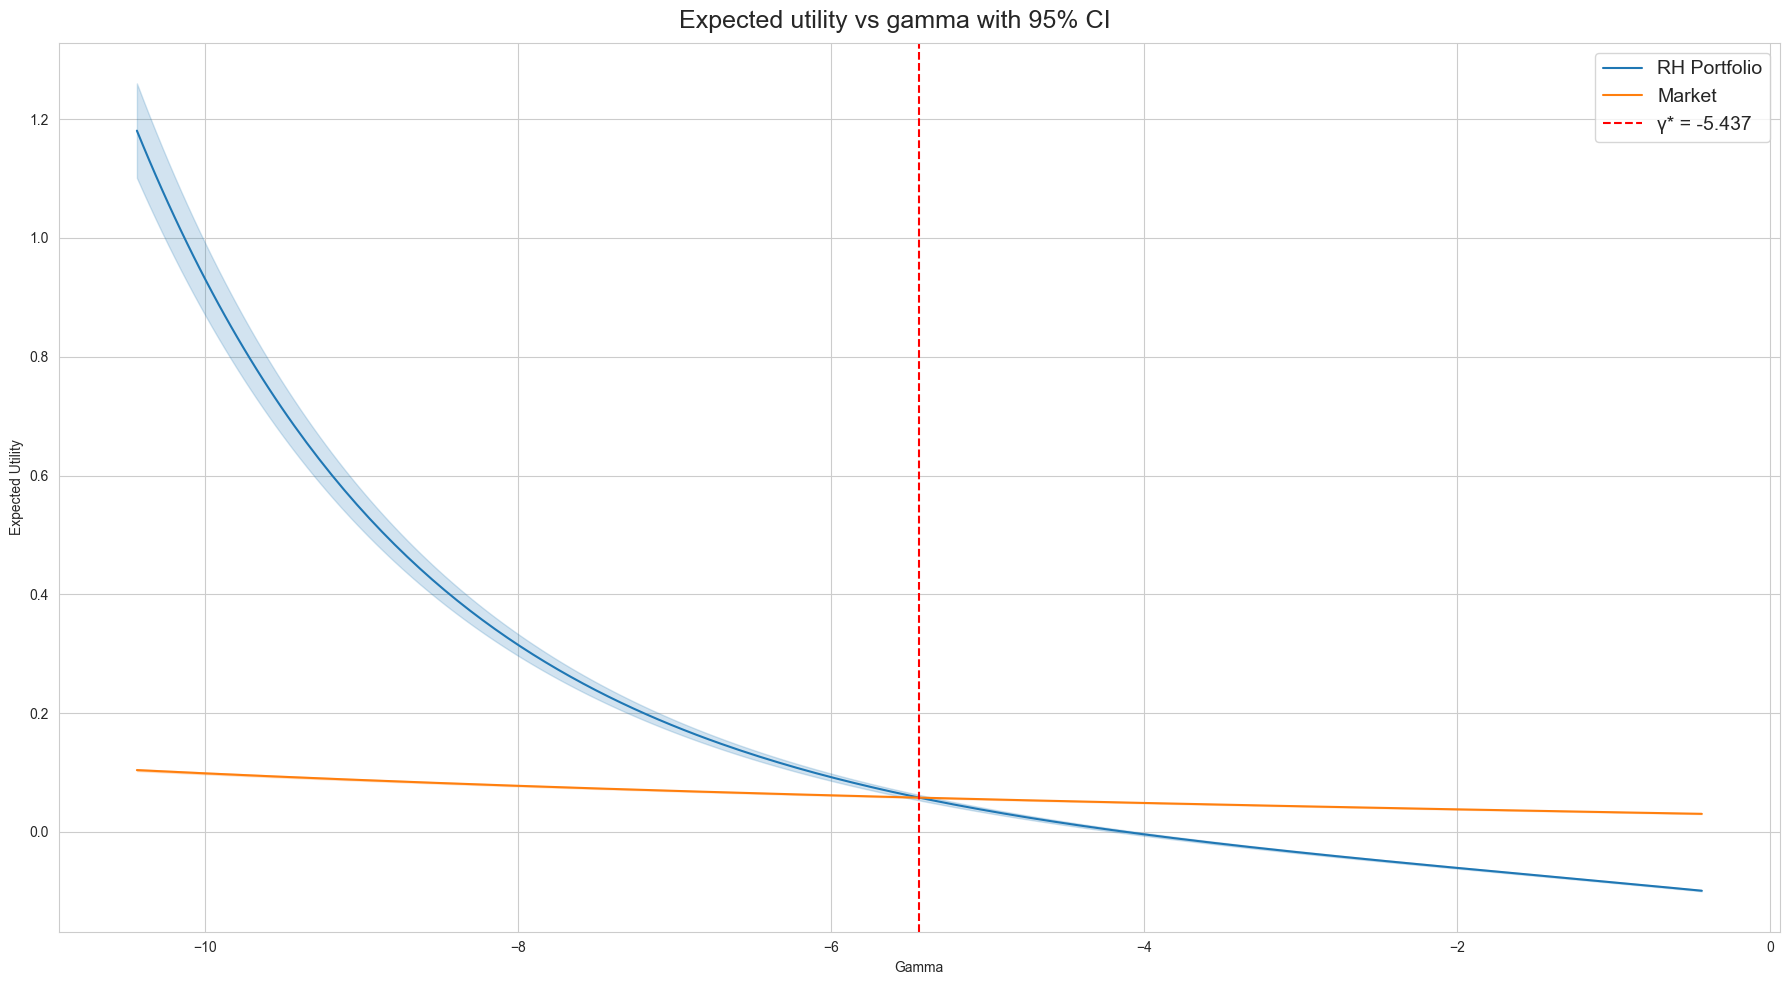

np.float64(-5.437281299436248)

In [ ]:

rt_wealth.find_cutoff_gamma(df_returns=all_ret_df-1)

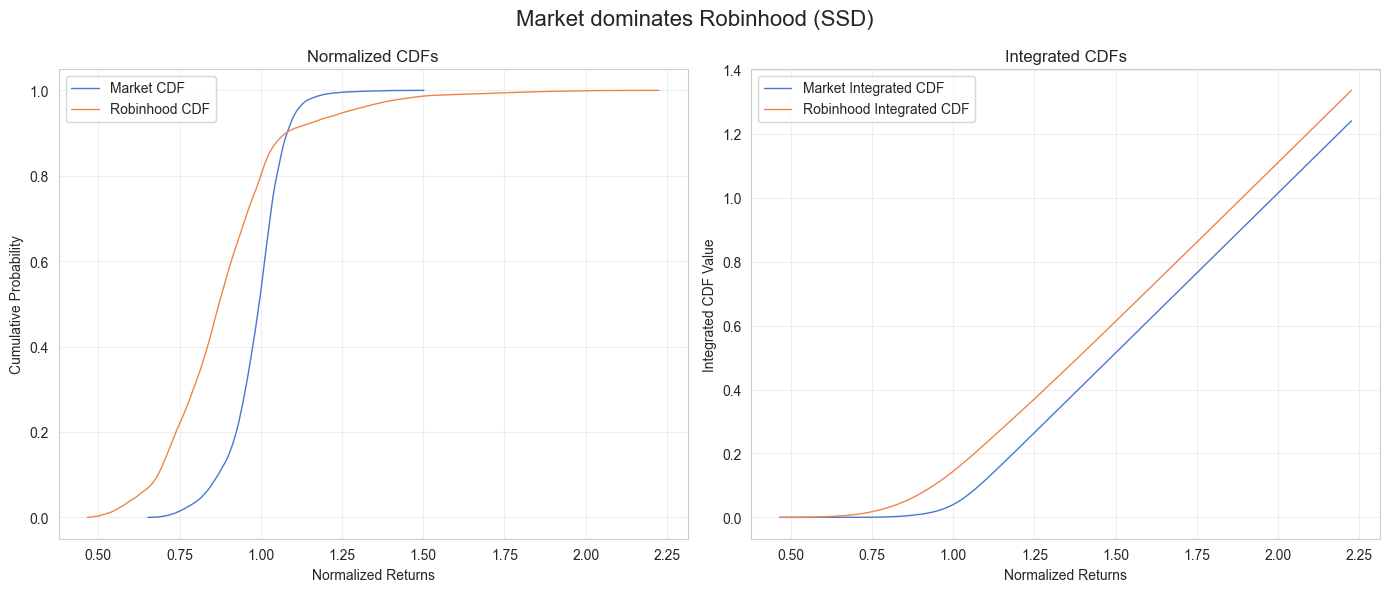

np.True_

In [33]:
from src.visuals.plotter import Plotter, ReturnSeries


plotter = Plotter([ReturnSeries(label="GMM", df=all_ret_df, horizons=[1])])
plotter.plot_ssd_comparison(all_ret_df["xmkt"], all_ret_df["xr"], "Market", "Robinhood")

**Can't do bootstrapping as it assumes independent samples**

## Euler

In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
from src import Analyzer
from src import RiskTests
from src.utils.params import ReturnParams

import numpy as np

return_params = ReturnParams(
    horizons={},  
    start_date=None,
#    end_date="2020-02-03",
    cumulative=False,
    append_start=False
)

an_wealth = Analyzer(compare_tickers=[], return_params=return_params, stocks_only=False, weights_application="wealth", dl_kwargs={"weights_method":"dollar"})


rt_wealth = RiskTests(an_wealth)
daily_factors = rt_wealth.factors
daily_factors.describe()

2025-05-18 12:47:27,525 - src.analyzer - INFO - ------------------------------ Analysis Started ------------------------------ (analyzer.py:80)
2025-05-18 12:47:30,718 - src.analyzer - WARNING - Empty dataframe produced for tickers: [] (analyzer.py:204)


,xmkt,smb,hml,rmw,cma,rf,umd,rh_portfolio,xr,mkt
count,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000
mean,0.000460,-0.000415,-0.000761,0.000168,-0.000053,0.000066,0.000084,0.000609,0.000544,0.000526
std,0.016153,0.007641,0.010633,0.004251,0.003877,0.000033,0.012773,0.020192,0.020195,0.016152
min,-0.120000,-0.045800,-0.047100,-0.017900,-0.015700,0.000000,-0.061800,-0.117828,-0.117888,-0.119940
25%,-0.004100,-0.004300,-0.005400,-0.002400,-0.002300,0.000060,-0.005200,-0.006983,-0.007065,-0.004025
50%,0.001200,-0.000800,-0.001400,0.000100,-0.000200,0.000070,0.001000,0.000725,0.000635,0.001280
75%,0.006800,0.003350,0.004050,0.002600,0.001900,0.000090,0.005900,0.008794,0.008704,0.006890
max,0.093400,0.057300,0.045900,0.017000,0.014500,0.000100,0.060100,0.102957,0.102897,0.093460


In [ ]:
monthly_factors = rt_wealth.resample_factors()
monthly_factors

,xmkt,smb,hml,rmw,cma,rf,umd,rh_portfolio,mkt,xr
2018-06-30,-0.008748,0.010857,-0.022070,0.008557,0.004384,0.001201,-0.031092,0.009446,-0.007557,0.008236
2018-07-31,0.033894,-0.019207,0.004746,0.014948,0.003551,0.001681,-0.005693,-0.002451,0.035630,-0.004126
2018-08-31,0.039045,-0.000751,-0.032295,0.000409,-0.023410,0.001471,0.042673,0.072512,0.040571,0.070942
2018-09-30,-0.000283,-0.024684,-0.016728,0.005744,0.012667,0.001521,-0.004330,0.007566,0.001237,0.006036
2018-10-31,-0.070095,-0.048122,0.036704,0.010285,0.036205,0.001842,-0.018644,-0.105207,-0.068377,-0.106861
2018-11-30,0.017142,-0.008340,0.001784,-0.007094,0.001766,0.001681,-0.006195,0.001672,0.018851,-0.000010
2018-12-31,-0.095110,-0.032586,-0.022209,-0.002020,0.000086,0.001902,0.032665,-0.107692,-0.093380,-0.109396
2019-01-31,0.060217,0.022612,0.000087,-0.002161,-0.003700,0.001601,-0.049336,0.132882,0.061908,0.131084
2019-02-28,0.030542,0.017655,-0.025703,0.000740,-0.013769,0.001902,-0.004594,0.056941,0.032499,0.054940
2019-03-31,0.011638,-0.034674,-0.041895,0.008130,-0.010597,0.001892,0.015804,0.010753,0.013551,0.008846


In [ ]:
gamma_gmm = rt_wealth.estimate_euler_gamma(df_returns=daily_factors)
gamma_gmm

np.float64(3.0714922378400455)

Gamma: 1.93963


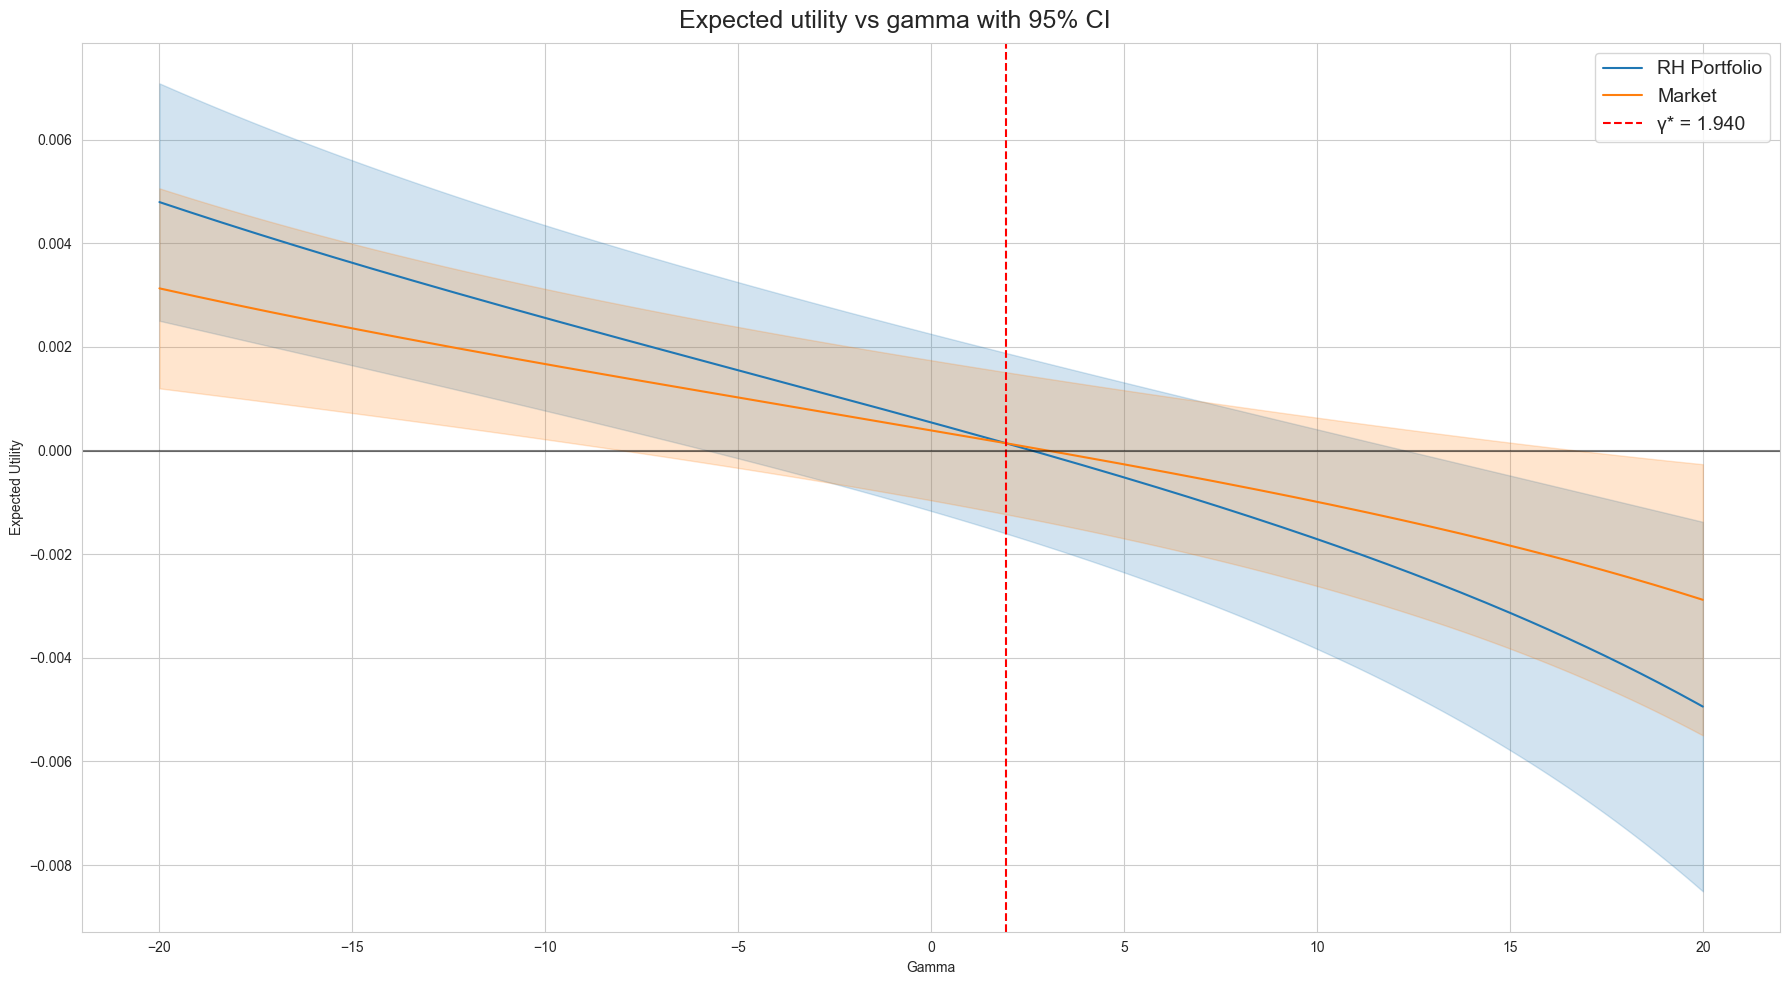

gammaaaaa: 1.93963276190716


In [ ]:
g = rt_wealth.find_cutoff_gamma(bounds=(-20,20))
print(f"gamm: {g}")

In [ ]:
df_wealth = daily_factors +1
df_wealth

,rh_portfolio,rf,mkt,xr,xmkt
2018-06-04,1.007979,1.00006,1.005061,1.007919,1.005001
2018-06-05,1.007667,1.00006,0.999735,1.007607,0.999675
2018-06-06,1.009567,1.00006,1.008749,1.009507,1.008689
2018-06-07,0.995441,1.00006,0.996583,0.995381,0.996523
2018-06-08,1.003475,1.00006,1.002242,1.003415,1.002182
...,...,...,...,...,...
2020-08-07,0.996141,1.00000,0.996542,0.996141,0.996542
2020-08-10,1.019014,1.00000,1.002726,1.019014,1.002726
2020-08-11,0.980078,1.00000,0.996910,0.980078,0.996910
2020-08-12,1.006672,1.00000,1.015001,1.006672,1.015001


In [ ]:
rt_wealth.bootstrap_difference_utility(df_returns=df_wealth, gamma0=gamma_gmm)

ΔU (xmkt - rh_portfolio) at γ=3.071: -0.00017 [-0.00097, 0.00061]


(np.float64(-0.00017284581852384324),
 np.float64(-0.0009742359888587294),
 np.float64(0.0006114926814635308))

In [39]:
daily_factors

,rh_portfolio,rf,mkt,xr,xmkt
2018-06-04,0.007979,0.00006,0.005061,0.007919,0.005001
2018-06-05,0.007667,0.00006,-0.000265,0.007607,-0.000325
2018-06-06,0.009567,0.00006,0.008749,0.009507,0.008689
2018-06-07,-0.004559,0.00006,-0.003417,-0.004619,-0.003477
2018-06-08,0.003475,0.00006,0.002242,0.003415,0.002182
...,...,...,...,...,...
2020-08-07,-0.003859,0.00000,-0.003458,-0.003859,-0.003458
2020-08-10,0.019014,0.00000,0.002726,0.019014,0.002726
2020-08-11,-0.019922,0.00000,-0.003090,-0.019922,-0.003090
2020-08-12,0.006672,0.00000,0.015001,0.006672,0.015001


In [ ]:
rt_wealth.bootstrap_gamma(daily_factors)

γ̂^GMM = 3.0715
95% BCa CI = [0.9072, 19.8172]


{'gamma_estimate': np.float64(3.0714922378400455),
 'ci_lower': np.float64(0.9072428346440041),
 'ci_upper': np.float64(19.817195964133305),
 'confidence_level': 0.95,
 'n_resamples': 5000}

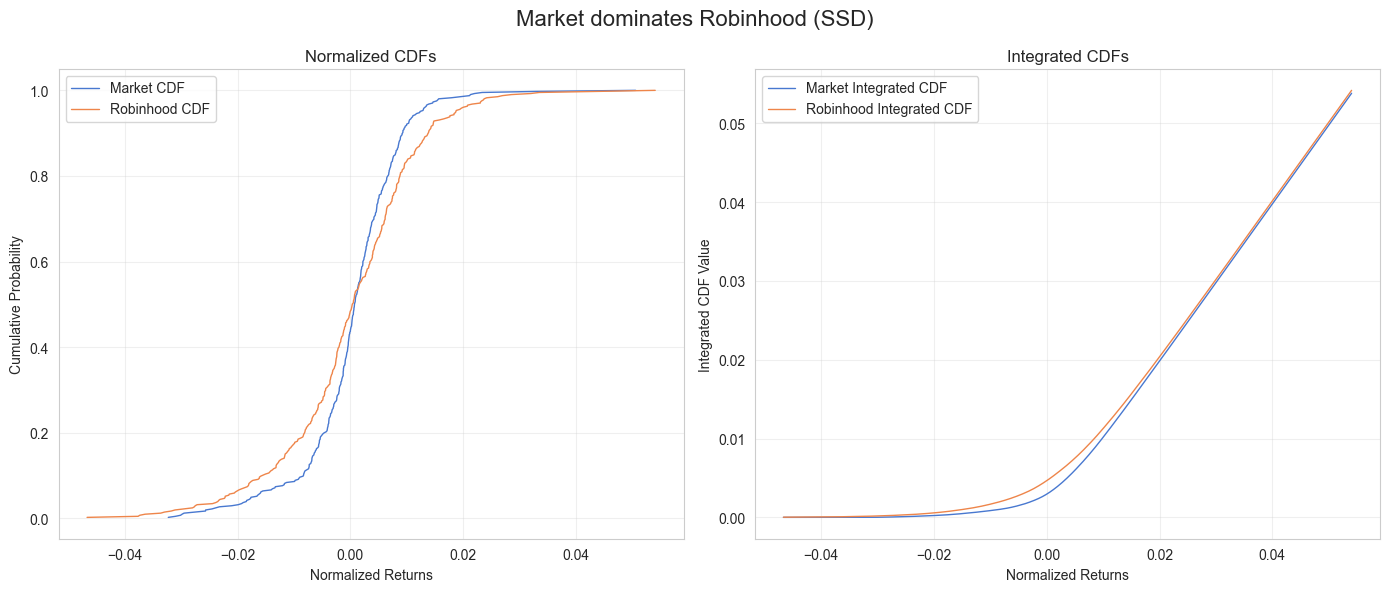

np.True_

In [45]:
from src.visuals.plotter import Plotter, ReturnSeries


plotter = Plotter([ReturnSeries(label="GMM", df=daily_factors, horizons=[])])
plotter.plot_ssd_comparison(daily_factors["mkt"], daily_factors["rh_portfolio"], "Market", "Robinhood")

## $\gamma$ in a given interval

In [3]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import numpy as np
import pandas as pd

from src import Analyzer
from src import RiskTests
from src.utils.params import ReturnParams



return_params = ReturnParams(
    horizons={30},  
    start_date=None,
#    end_date="2020-02-03",
    cumulative=False,
    append_start=False
)

an_wealth = Analyzer(compare_tickers=["VOO"], return_params=return_params, stocks_only=False, weights_application="wealth", dl_kwargs={"weights_method":"dollar"})
rt_wealth = RiskTests(an_wealth, ff_mkt_index=False)
an_number = Analyzer(compare_tickers=["VT"], return_params=return_params, stocks_only=False, weights_application="number", dl_kwargs={"weights_method":"dollar"})
rt_number = RiskTests(an_number, ff_mkt_index=False)


2025-05-27 18:41:26,001 - src.analyzer - INFO - ------------------------------ Analysis Started ------------------------------ (analyzer.py:80)
2025-05-27 18:41:29,955 - src.analyzer - INFO - ------------------------------ Analysis Started ------------------------------ (analyzer.py:80)


### Estimating $\gamma$ in closed form

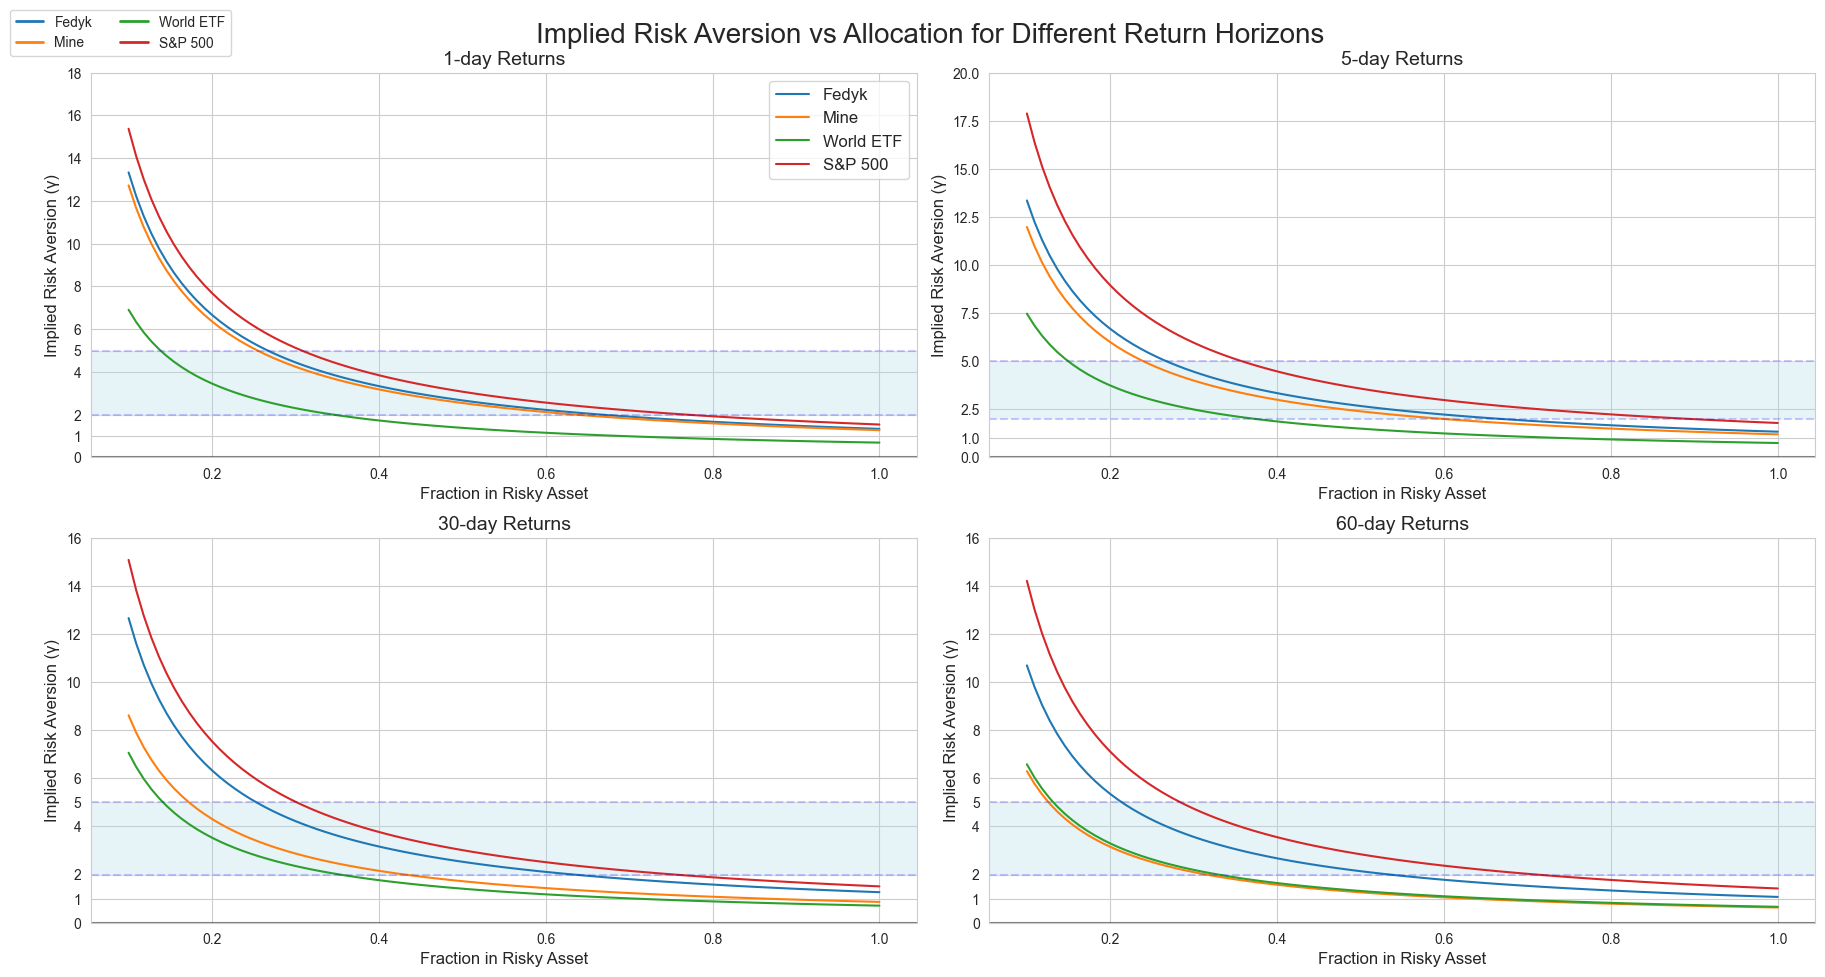

In [ ]:
from src.utils.metrics import gamma_closed_form

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

mkt = "xmkt"
days = [1, 5, 30, 60]

# Set up the subplot grid
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(18, ))
axes = axes.flatten()  # Flatten for easier indexing

alphas = np.linspace(0.1, 1, 100)

for i, d in enumerate(days):
    ax = axes[i]
    
    # Resample data for current d
    df_wealth = rt_wealth.resample_factors(f"{d}D")
    df_number = rt_number.resample_factors(f"{d}D")

    df_wealth = df_wealth[["xr", "xmkt"]]
    df_wealth = df_wealth[(df_wealth != 0).all(axis=1)]

    df_number = df_number[["xr", "xmkt"]]
    df_number = df_number[(df_number != 0).all(axis=1)]

    # Calculate utilities
    utilities_wealth = [gamma_closed_form(df_wealth["xr"], a) for a in alphas]
    utilities_number = [gamma_closed_form(df_number["xr"], a) for a in alphas]
    utilities_voo = [gamma_closed_form(df_wealth[mkt], a) for a in alphas]
    utilities_vt = [gamma_closed_form(df_number[mkt], a) for a in alphas]

    # Highlight the γ range between 2 and 5
    ax.axhspan(2, 5, facecolor='lightblue', alpha=0.3)

    # Plot lines
    sns.lineplot(x=alphas, y=utilities_wealth, ax=ax, label='Fedyk')
    sns.lineplot(x=alphas, y=utilities_number, ax=ax, label='Mine')
    sns.lineplot(x=alphas, y=utilities_vt, ax=ax, label='World ETF')
    sns.lineplot(x=alphas, y=utilities_voo, ax=ax, label='S&P 500')

    # Horizontal reference lines
    ax.axhline(0, color='black', alpha=0.5)
    ax.axhline(2, color='blue', linestyle="--", alpha=0.2)
    ax.axhline(5, color='blue', linestyle="--", alpha=0.2)

    # Labels and formatting
    ax.set_xlabel('Fraction in Risky Asset', fontsize=12)
    ax.set_ylim(0)
    ax.set_ylabel('Implied Risk Aversion (γ)', fontsize=12)
    ax.set_title(f'{d}-day Returns', fontsize=14)

    # Fix y-ticks to include 1 and 5
    current = list(ax.get_yticks())
    for y in (1, 5):
        if y not in current:
            current.append(y)
    current = sorted(current)
    ax.set_yticks(current)

    # Add legend only to the first subplot to avoid clutter
    if i == 0:
        ax.legend(fontsize=12)

# Overall title
fig.suptitle('Implied Risk Aversion vs Allocation for Different Return Horizons', fontsize=20, y=0.98)

# Add a single legend for all subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.05, 1),
           ncol=(len(labels)//4+1), frameon=True, fontsize='medium')

# Remove individual legends from other subplots
for ax in axes[1:]:
    ax.legend().set_visible(False)

plt.tight_layout()
plt.subplots_adjust(top=0.93, bottom=0.08)  # Make room for suptitle and legend
plt.show()

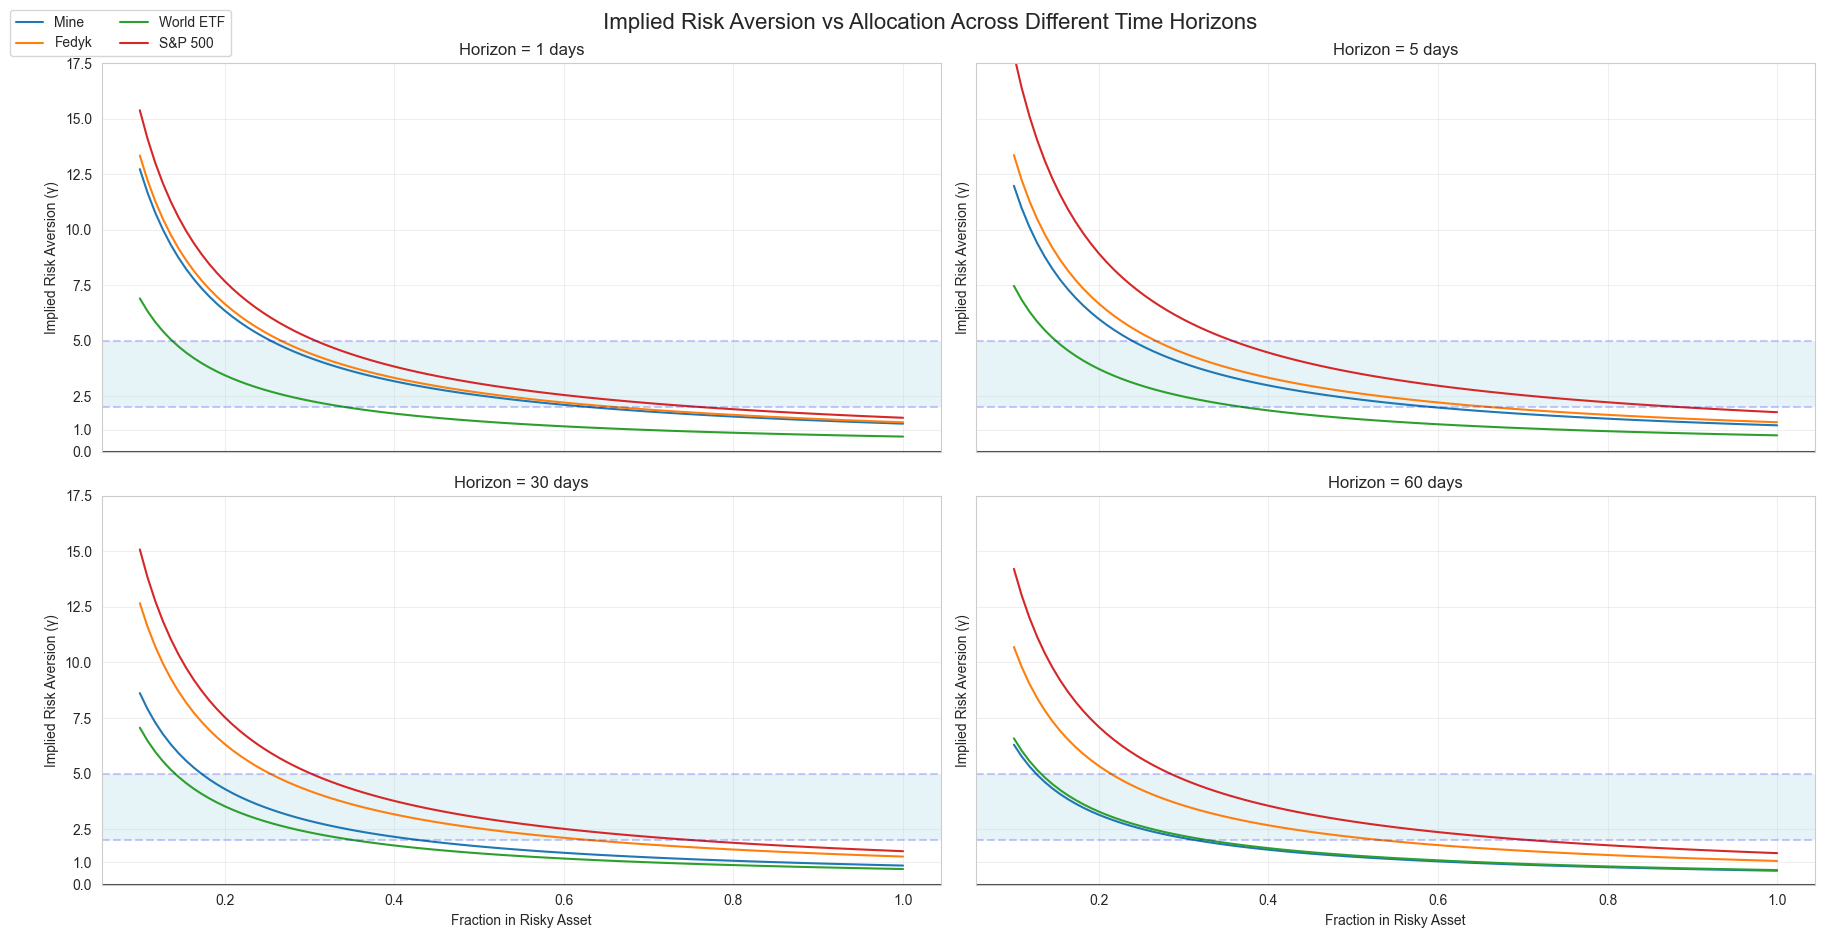

In [121]:
from src.utils.metrics import gamma_closed_form

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")

# Different d values for each subplot
d_values = [1, 5, 30, 60]

mkt = "xmkt"
alphas = np.linspace(0.1, 1, 100)

# Create 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=True, sharey=True)
fig.suptitle('Implied Risk Aversion vs Allocation Across Different Time Horizons', fontsize=16, y=0.98)

# Flatten axes for easier iteration
axes_flat = axes.flatten()
lines, labels = [], []

for idx, d in enumerate(d_values):
    ax = axes_flat[idx]
    
    # Resample data for current d
    df_wealth = rt_wealth.resample_factors(f"{d}D")
    df_number = rt_number.resample_factors(f"{d}D")

    df_wealth = df_wealth[["xr", "xmkt"]]
    df_wealth = df_wealth[(df_wealth != 0).all(axis=1)]

    df_number = df_number[["xr", "xmkt"]]
    df_number = df_number[(df_number != 0).all(axis=1)]

    # Calculate utilities
    utilities_wealth = [gamma_closed_form(df_wealth["xr"], a) for a in alphas]
    utilities_number = [gamma_closed_form(df_number["xr"], a) for a in alphas]
    utilities_voo = [gamma_closed_form(df_wealth[mkt], a) for a in alphas]
    utilities_vt = [gamma_closed_form(df_number[mkt], a) for a in alphas]

    # Highlight the γ range between 2 and 5
    ax.axhspan(2, 5, facecolor='lightblue', alpha=0.3)

    # Plot lines
    line1 = ax.plot(alphas, utilities_number, color='C0', linewidth=1.5, label='_nolegend_')
    line2 = ax.plot(alphas, utilities_wealth, color='C1', linewidth=1.5, label='_nolegend_')
    line3 = ax.plot(alphas, utilities_vt, color='C2', linewidth=1.5, label='_nolegend_')
    line4 = ax.plot(alphas, utilities_voo, color='C3', linewidth=1.5, label='_nolegend_')

    # Store lines and labels for the legend (only from first subplot)
    if idx == 0:
        lines.append(line1[0])
        lines.append(line2[0])
        lines.append(line3[0])
        lines.append(line4[0])
        labels.append('Mine')
        labels.append('Fedyk')
        labels.append('World ETF')
        labels.append('S&P 500')

    # Remove any existing legend
    if ax.get_legend() is not None:
        ax.get_legend().remove()

    # Horizontal reference lines
    ax.axhline(0, color='black', linestyle='-', alpha=0.7)
    ax.axhline(2, color='blue', linestyle="--", alpha=0.2)
    ax.axhline(5, color='blue', linestyle="--", alpha=0.2)

    # Customize subplot
    ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=7))
    ax.set_xlabel('Fraction in Risky Asset' if (idx >= 2) else None)
    ax.set_ylim(0)
    ax.set_ylabel('Implied Risk Aversion (γ)')
    ax.set_title(f'Horizon = {d} days')
    
    # Fix y-ticks to include 1 and 5
    current = list(ax.get_yticks())
    for y in (1, 5):
        if y not in current:
            current.append(y)
    current = sorted(current)
    ax.set_yticks(current)
    
    ax.grid(True, alpha=0.3)

# Add shared legend
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.05, 0.99),
           ncol=2, frameon=True, fontsize='medium')

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.subplots_adjust(top=0.93)  # Make room for suptitle
plt.show()

In [ ]:
# Table for sharpe ratios

mkt = "xmkt"

days = [1, 5, 30, 60]

df = pd.DataFrame()

for d in days:
    df_wealth = rt_wealth.resample_factors(f"{d}D")
    df_number = rt_number.resample_factors(f"{d}D")

    df_wealth = df_wealth[["xr", "xmkt"]]
    df_wealth = df_wealth[(df_wealth != 0).all(axis=1)]

    df_number = df_number[["xr", "xmkt"]]
    df_number = df_number[(df_number != 0).all(axis=1)]

    df.loc[f"{d} Days", f"Fedyk"] = df_wealth["xr"].mean()/df_wealth["xr"].std() 
    df.loc[f"{d} Days", f"Mine"] = df_number["xr"].mean()/df_number["xr"].std() 
    df.loc[f"{d} Days", f"S&P 500"] = df_wealth["xmkt"].mean()/df_wealth["xmkt"].std() 
    df.loc[f"{d} Days", f"World ETF"] = df_number["xmkt"].mean()/df_number["xmkt"].std() 

    


df.T.round(3)

,1 Days,5 Days,30 Days,60 Days
Fedyk,0.027,0.049,0.121,0.157
Mine,0.024,0.041,0.097,0.124
S&P 500,0.025,0.047,0.111,0.149
World ETF,0.010,0.018,0.051,0.069


In [ ]:
mkt = "xmkt"

days = [1, 5, 30, 60]

df = pd.DataFrame()

for d in days:
    df_wealth = rt_wealth.resample_factors(f"{d}D")
    df_number = rt_number.resample_factors(f"{d}D")

    df_wealth = df_wealth[["xr", "xmkt"]]
    df_wealth = df_wealth[(df_wealth != 0).all(axis=1)]

    df_number = df_number[["xr", "xmkt"]]
    df_number = df_number[(df_number != 0).all(axis=1)]


    alphas = np.linspace(0, 1, 2000)


    gammas_wealth   = [gamma_closed_form(df_wealth["xr"], a) for a in alphas]
    gammas_number   = [gamma_closed_form(df_number["xr"], a) for a in alphas]
    gammas_voo = [gamma_closed_form(df_wealth[mkt], a) for a in alphas]
    gammas_vt = [gamma_closed_form(df_number[mkt], a) for a in alphas]

    u_dict = {"Fedyk":gammas_wealth,
              "Mine":gammas_number,
              "S&P 500":gammas_voo,
              "World ETF":gammas_vt}
    

    for k, v in u_dict.items():
        for value in [2,5]:
            try:
                index = np.where(np.isclose(v, value, atol=1e-2))[0][0] 
                alpha = alphas[index]
            except IndexError:
                alpha = np.nan
            
            

            df.loc[d, f"{k} - {value}"] = alpha 

df.T.round(3)

,1,5,30,60
Fedyk - 2,0.664,0.665,0.630,0.532
Fedyk - 5,0.267,0.267,0.253,0.214
Mine - 2,0.633,0.596,0.429,0.314
Mine - 5,0.254,0.239,0.173,0.126
S&P 500 - 2,0.765,0.890,0.751,0.707
S&P 500 - 5,0.307,0.357,0.301,0.284
World ETF - 2,0.344,0.372,0.352,0.328
World ETF - 5,0.138,0.150,0.141,0.132


In [124]:
mkt = "xmkt"

days = [1, 5, 30, 60]

df = pd.DataFrame()

for d in days:
    df_wealth = rt_wealth.resample_factors(f"{d}D")
    df_number = rt_number.resample_factors(f"{d}D")

    df_wealth = df_wealth[["xr", "xmkt"]]
    df_wealth = df_wealth[(df_wealth != 0).all(axis=1)]

    df_number = df_number[["xr", "xmkt"]]
    df_number = df_number[(df_number != 0).all(axis=1)]

    # generate table to see the risk aversion 
    a = 1

    gammas_wealth   = gamma_closed_form(df_wealth["xr"], a)
    gammas_number   = gamma_closed_form(df_number["xr"], a) 
    gammas_voo = gamma_closed_form(df_wealth[mkt], a) 
    gammas_vt = gamma_closed_form(df_number[mkt], a) 

    u_dict = {"Fedyk":gammas_wealth,
              "Mine":gammas_number,
              "S&P 500":gammas_voo,
              "World ETF":gammas_vt}
    

    for k, v in u_dict.items():
        df.loc[d, k] = v

df.T.round(3)

,1,5,30,60
Fedyk,1.333,1.336,1.267,1.070
Mine,1.272,1.197,0.862,0.630
S&P 500,1.537,1.788,1.509,1.421
World ETF,0.691,0.747,0.707,0.658
